# Assignment 1: Advanced analytics [D0S07a]

## Group 29

Predictive modeling on a tabular data: telco churn prediction <br>
The model will be evaluated using two metrics: profit @ top-20, and AUC

### First look

In [48]:
# Load necessary libraries
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno
import datetime as dt
import category_encoders as ce

from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.metrics import auc,f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score, roc_auc_score,roc_curve, classification_report, make_scorer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.preprocessing import StandardScaler,Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import LocalOutlierFactor

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
from joblib import dump, load
from math import exp
import shap

In [49]:
# Load dataset
dataset = pd.read_csv('C:/Users/Romain/OneDrive - KU Leuven/Masters/MBIS/Year 1/Semester 2/Big Data Platforms and Technologies/AdvancedAnalytic/train.csv')
validation = pd.read_csv('C:/Users/Romain/OneDrive - KU Leuven/Masters/MBIS/Year 1/Semester 2/Big Data Platforms and Technologies/AdvancedAnalytic/validation.csv')
test=pd.read_csv('C:/Users/Romain/OneDrive - KU Leuven/Masters/MBIS/Year 1/Semester 2/Big Data Platforms and Technologies/AdvancedAnalytic/test.csv')
display(dataset)

,Gender,Age,Connect_Date,L_O_S,Dropped_Calls,tariff,Handset,Peak_calls_Sum,Peak_mins_Sum,OffPeak_calls_Sum,...,Tariff_OK,average cost min,Peak ratio,OffPeak ratio,Weekend ratio,Nat-InterNat Ratio,high Dropped calls,No Usage,target,id
0,F,50.0,20/05/98,29.200000,2.0,Play 100,BS210,62.0,153.000000,185.0,...,OK,0.150531,0.246536,0.706735,0.046729,0.203034,F,F,0,K262360
1,M,25.0,16/12/96,46.533333,1.0,CAT 100,ASAD90,146.0,718.800000,98.0,...,OK,0.188988,0.780710,0.178886,0.040404,0.273249,F,F,1,K170160
2,F,46.0,27/08/97,38.066667,1.0,CAT 50,WC95,160.0,322.800000,7.0,...,OK,0.239300,0.722633,0.277367,0.000000,0.205025,F,F,0,K331610
3,F,59.0,13/07/98,27.400000,1.0,CAT 50,BS110,84.0,317.400001,57.0,...,OK,0.221467,0.662492,0.337508,0.000000,0.050090,F,F,0,K332460
4,F,25.0,08/01/99,21.433333,1.0,Play 300,WC95,14.0,309.600000,326.0,...,OK,0.107509,0.321896,0.663132,0.014972,0.090509,F,F,0,K394220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5039,F,16.0,15/09/97,37.433333,2.0,CAT 200,ASAD90,151.0,1169.400001,201.0,...,OK,0.130433,0.615895,0.346500,0.037605,0.127974,F,F,1,K192650
5040,F,29.0,28/09/96,49.166667,1.0,CAT 100,CAS30,135.0,405.600000,124.0,...,OK,0.189112,0.555769,0.412716,0.031515,0.238615,F,F,1,K295600
5041,M,23.0,08/06/99,16.400000,0.0,CAT 200,BS110,566.0,2382.000000,4.0,...,OK,0.112657,0.810121,0.162330,0.027548,0.043094,F,F,0,K366420
5042,M,46.0,01/03/98,31.866667,2.0,Play 100,S50,72.0,112.200000,31.0,...,OK,0.205957,0.323250,0.664650,0.012100,0.171451,F,F,1,K219850


### Data exploration

In [50]:
sorted_customers = dataset.sort_values(by='average cost min', ascending=False)

top20_churners = sorted_customers[sorted_customers['target'] == 1].head(20)

max_average_cost_min = top20_churners['average cost min'].sum()
print("max_average_cost_min:", max_average_cost_min)

max_average_cost_min: 12.651679


Outliers detected in column 'Age':


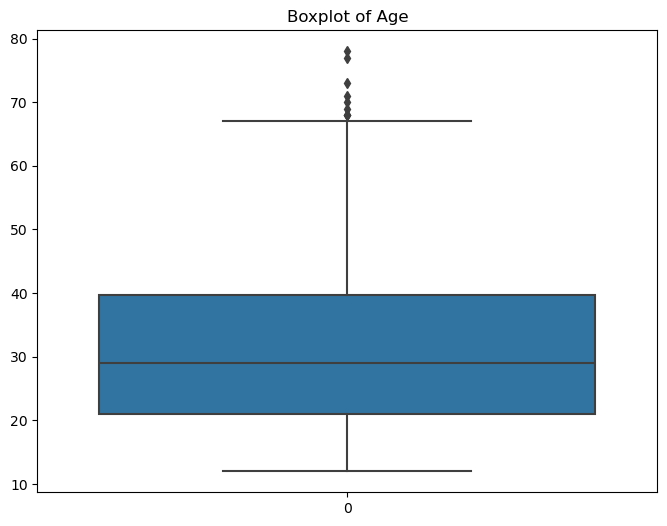

No outliers detected in column 'L_O_S'


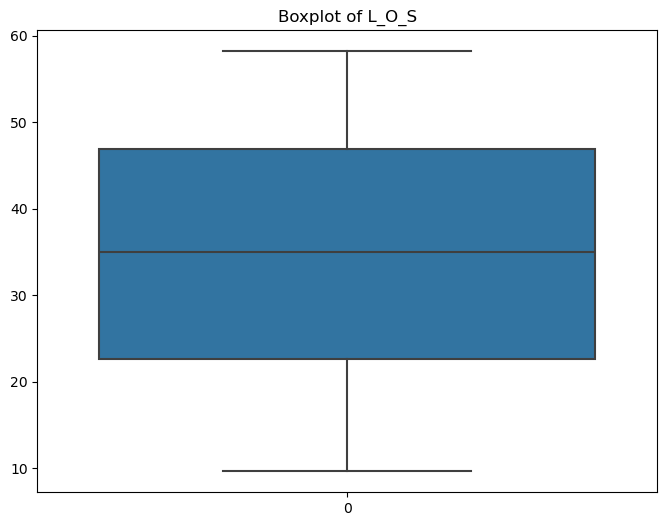

Outliers detected in column 'Dropped_Calls':


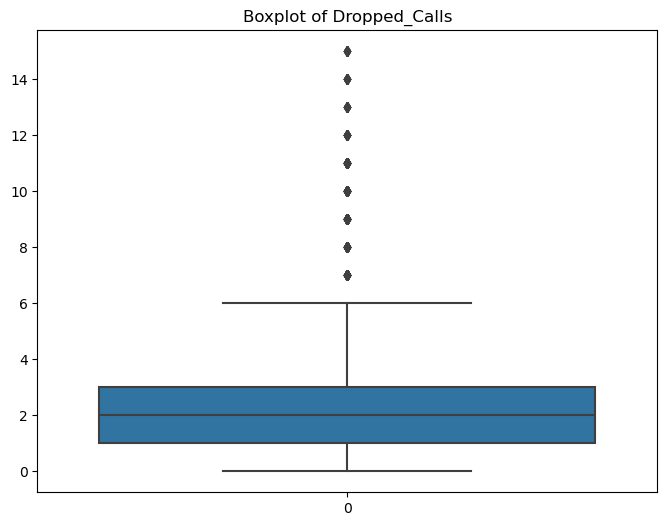

Outliers detected in column 'Peak_calls_Sum':


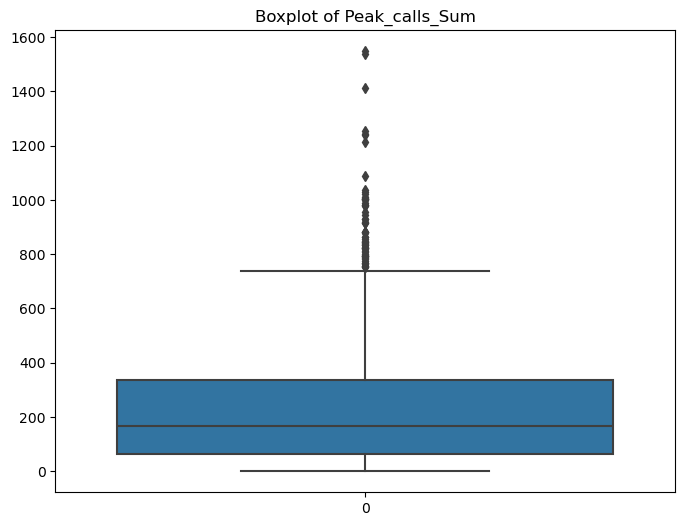

Outliers detected in column 'Peak_mins_Sum':


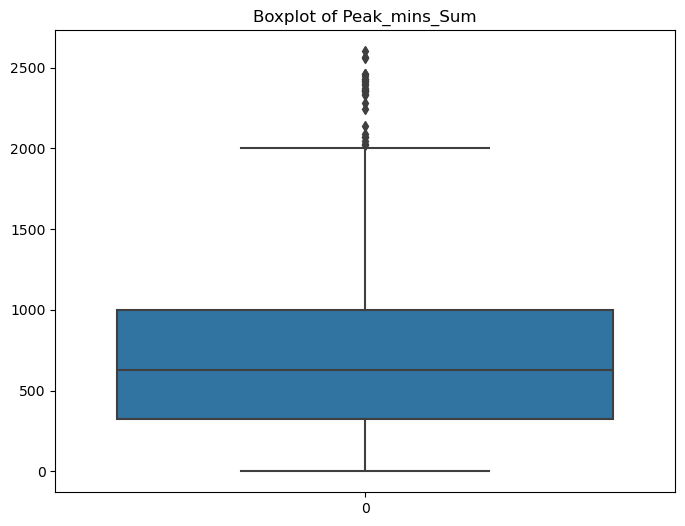

Outliers detected in column 'OffPeak_calls_Sum':


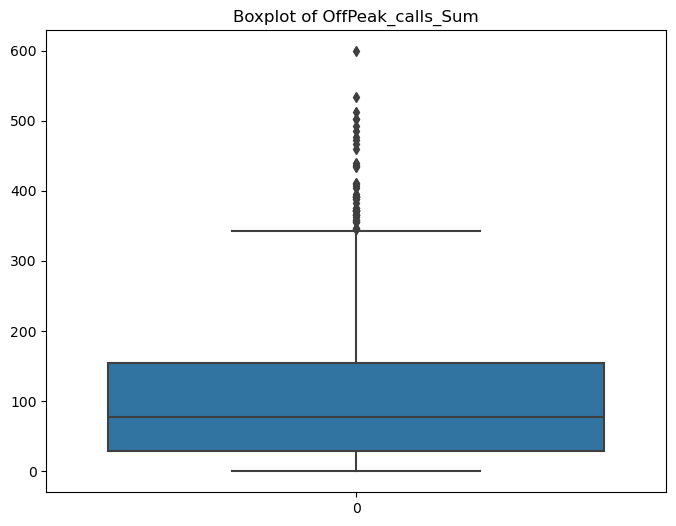

Outliers detected in column 'OffPeak_mins_Sum':


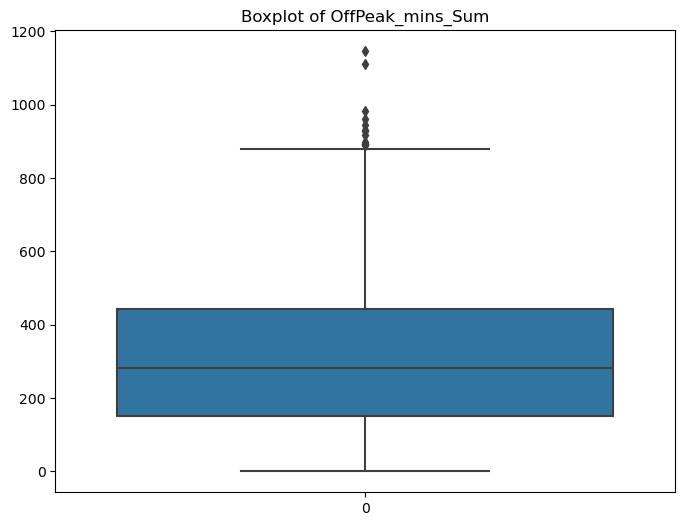

Outliers detected in column 'Weekend_calls_Sum':


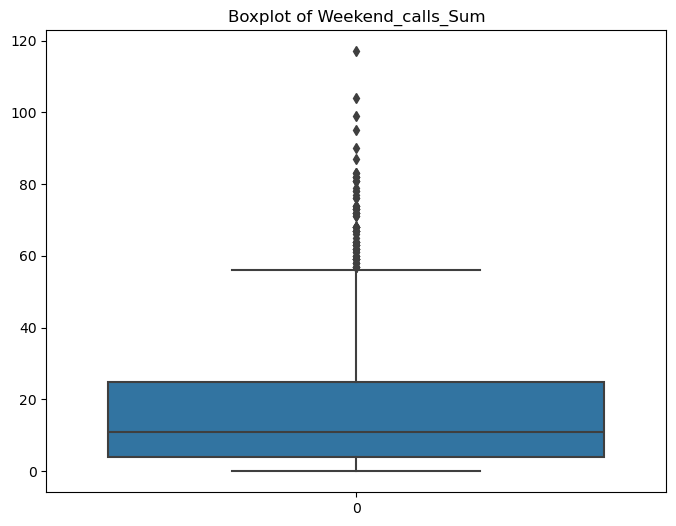

Outliers detected in column 'Weekend_mins_Sum':


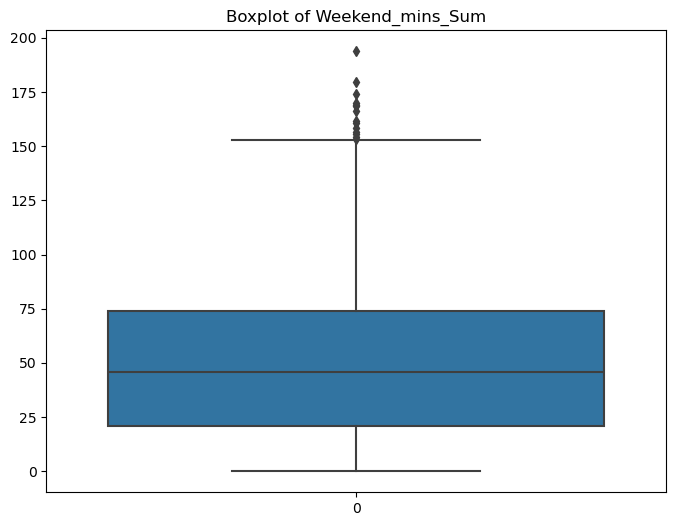

Outliers detected in column 'International_mins_Sum':


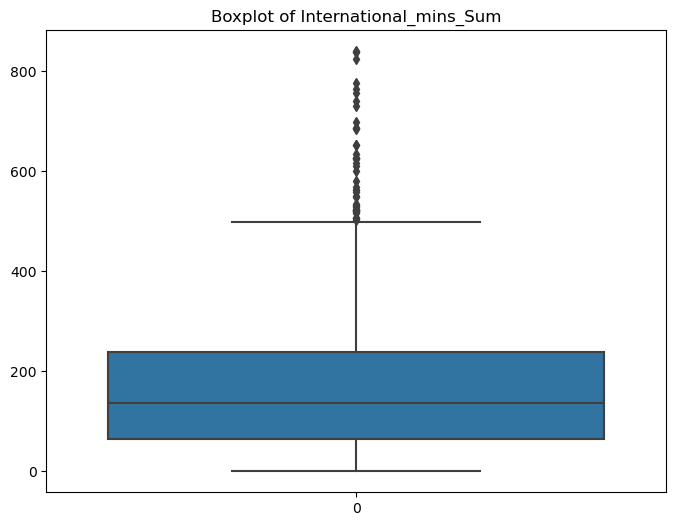

Outliers detected in column 'Nat_call_cost_Sum':


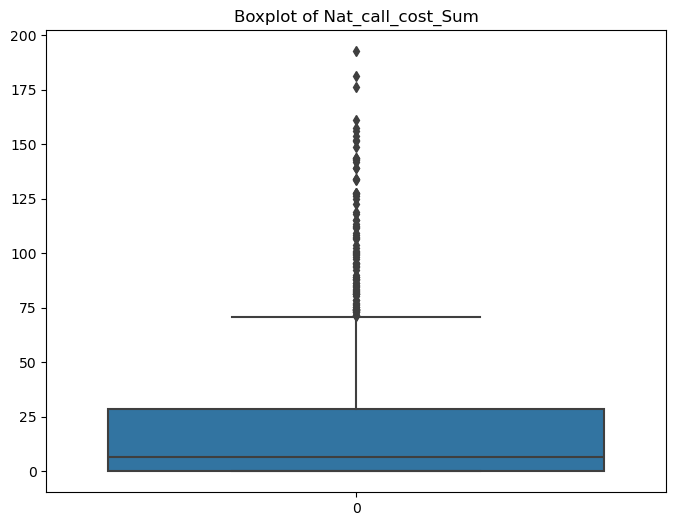

Outliers detected in column 'AvePeak':


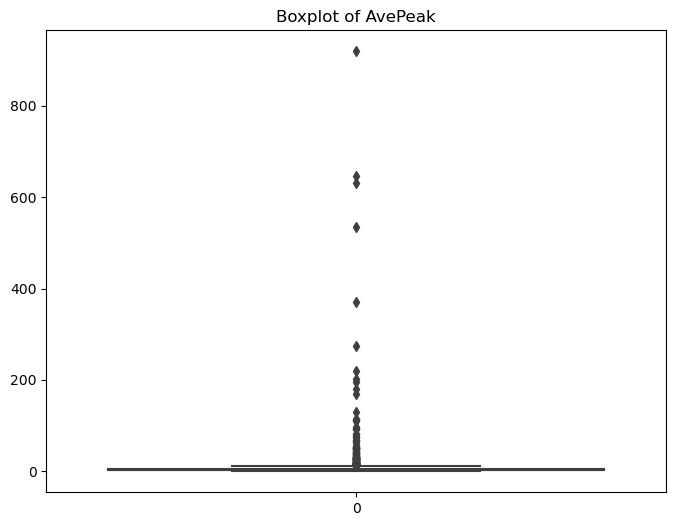

Outliers detected in column 'AveOffPeak':


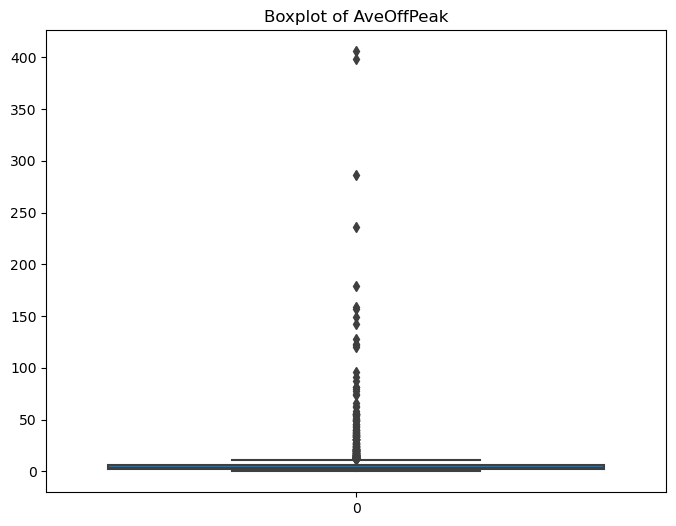

Outliers detected in column 'AveWeekend':


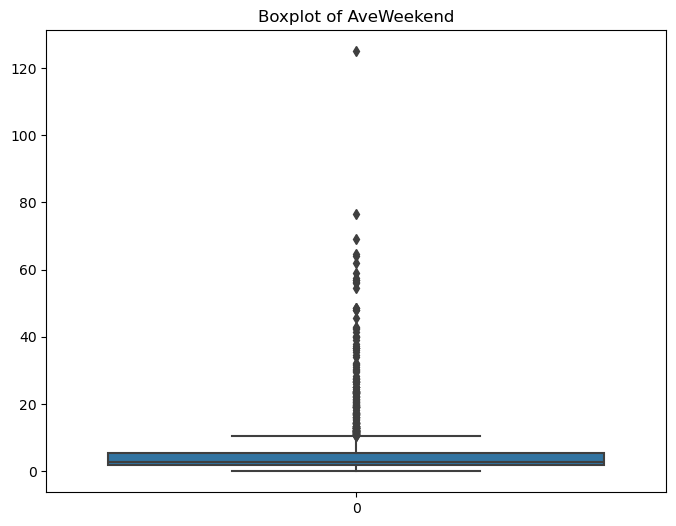

Outliers detected in column 'National_calls':


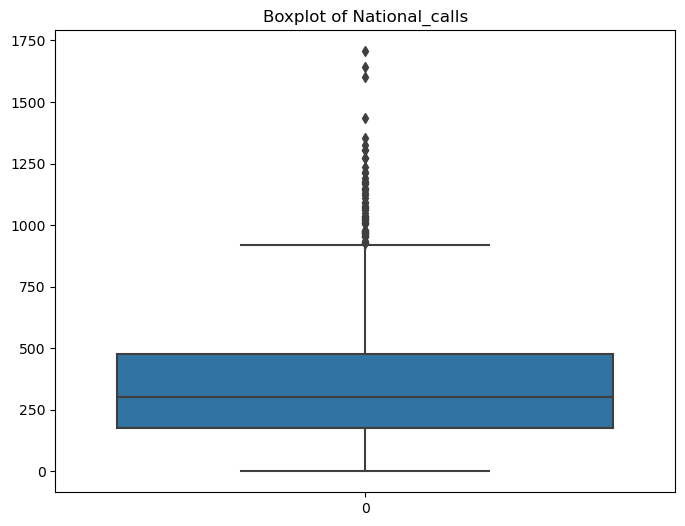

Outliers detected in column 'National mins':


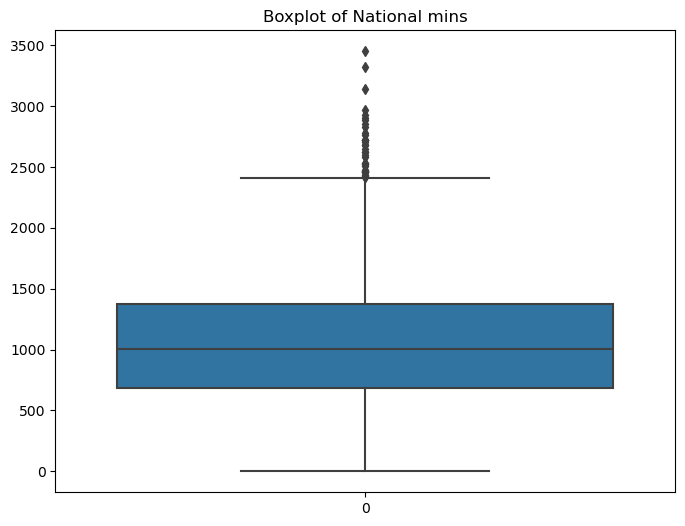

Outliers detected in column 'AveNational':


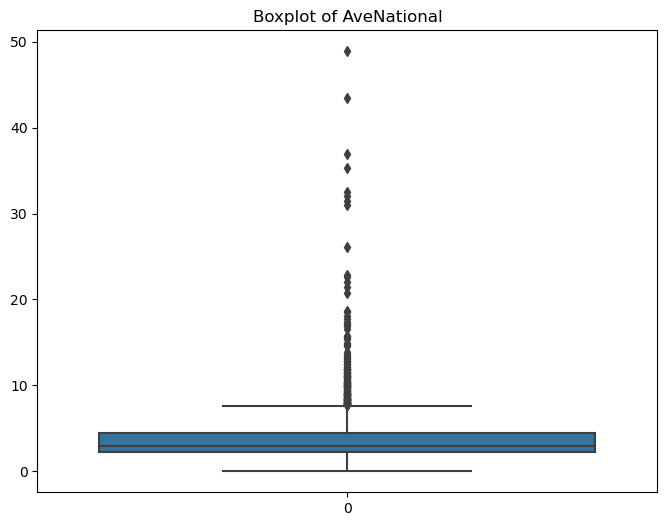

Outliers detected in column 'All_calls_mins':


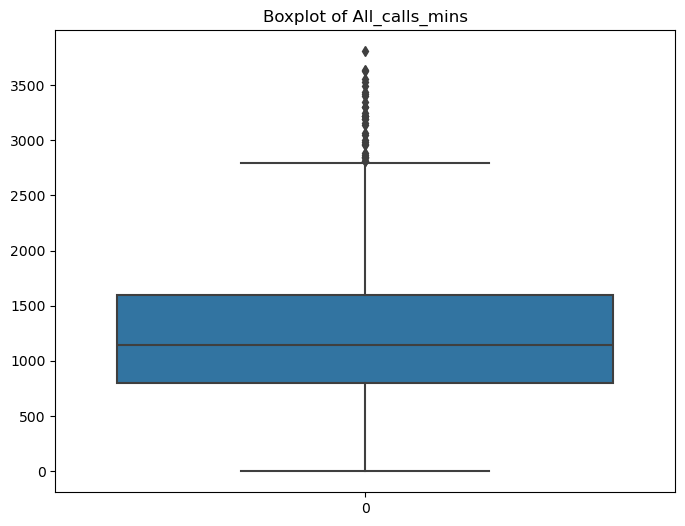

Outliers detected in column 'Dropped_calls_ratio':


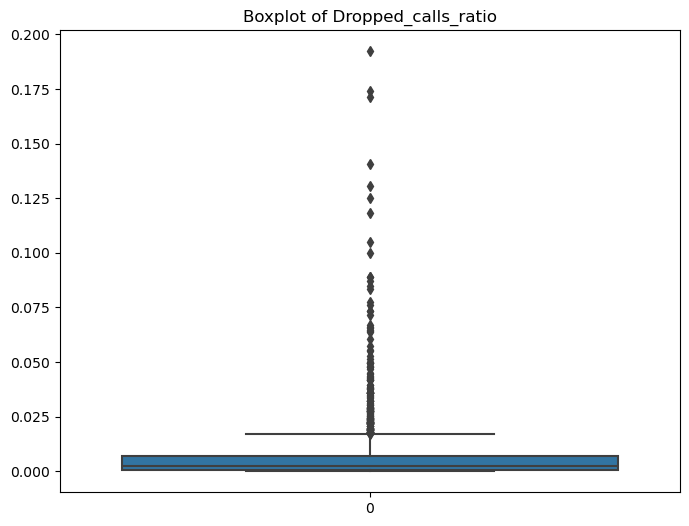

Outliers detected in column 'Mins_charge':


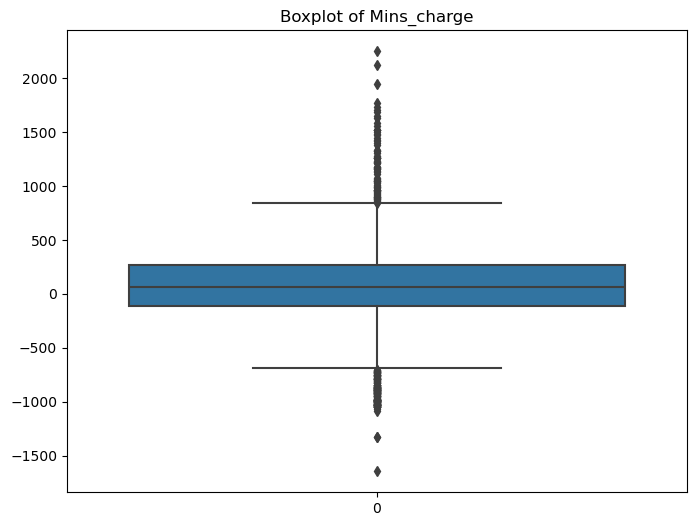

Outliers detected in column 'call_cost_per_min':


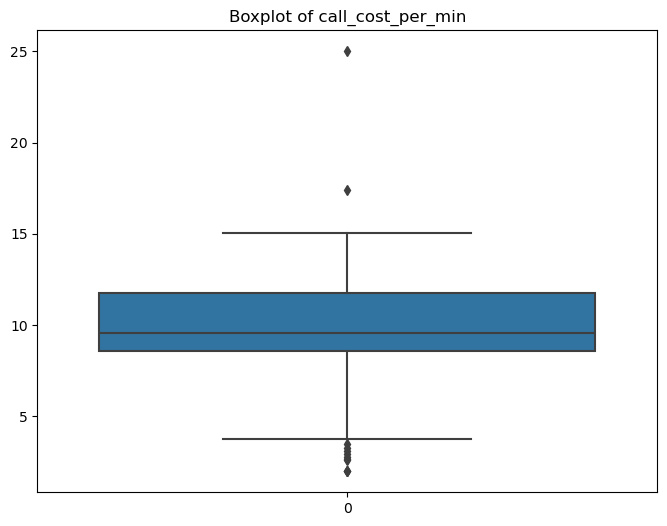

Outliers detected in column 'actual call cost':


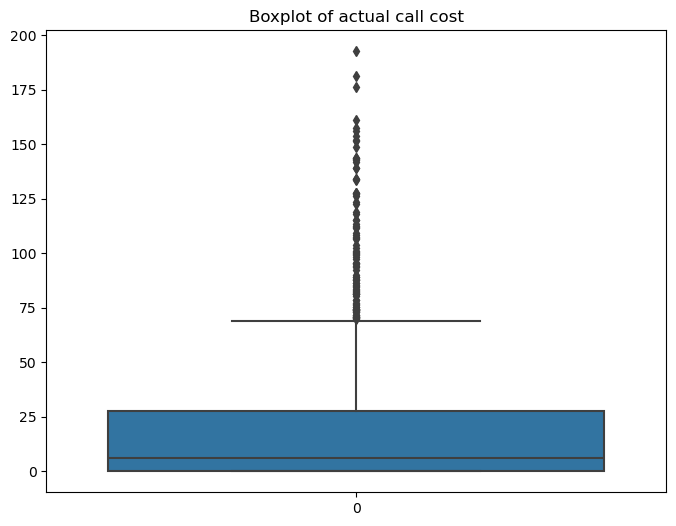

Outliers detected in column 'Total_call_cost':


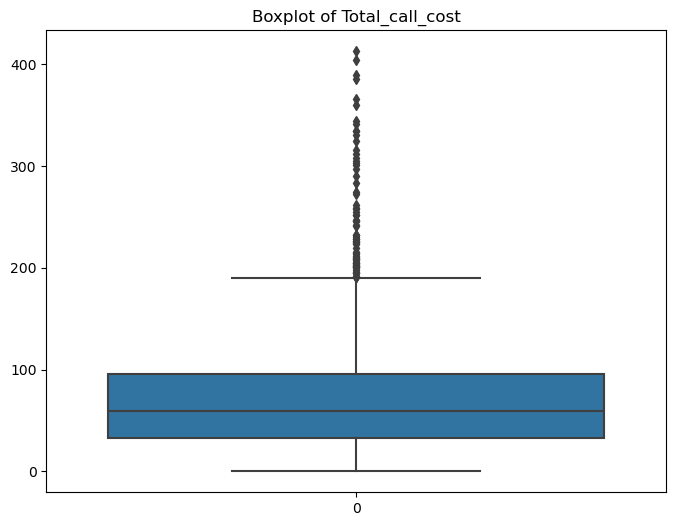

Outliers detected in column 'Total_Cost':


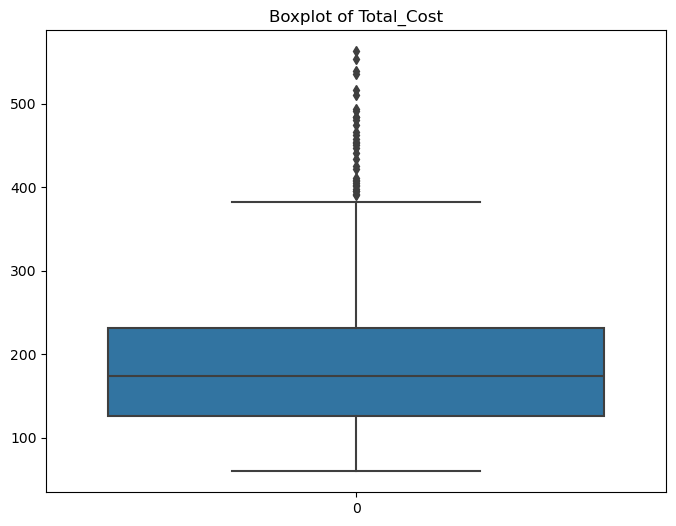

Outliers detected in column 'average cost min':


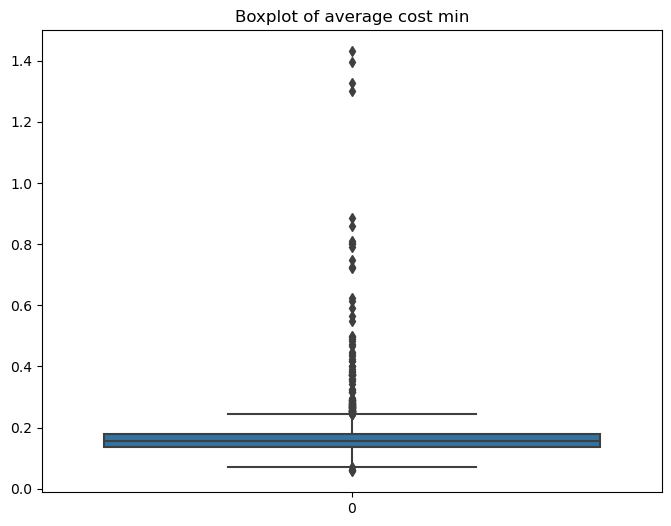

Outliers detected in column 'Peak ratio':


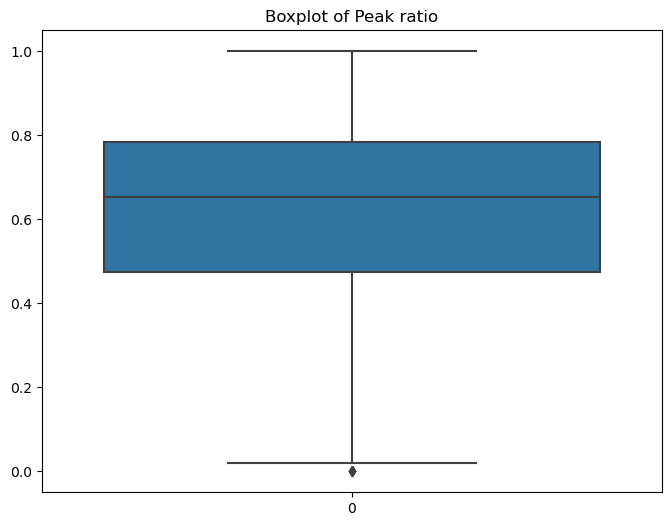

Outliers detected in column 'OffPeak ratio':


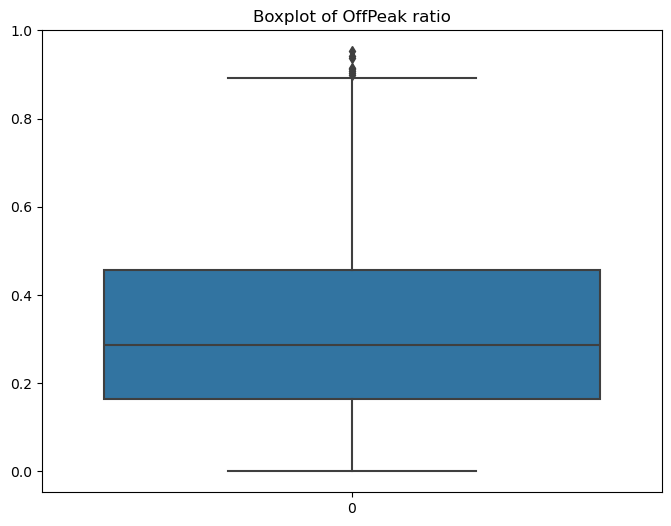

Outliers detected in column 'Weekend ratio':


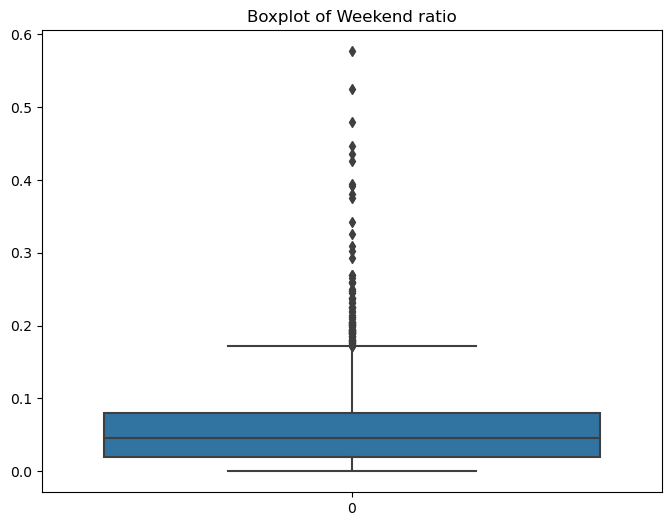

Outliers detected in column 'Nat-InterNat Ratio':


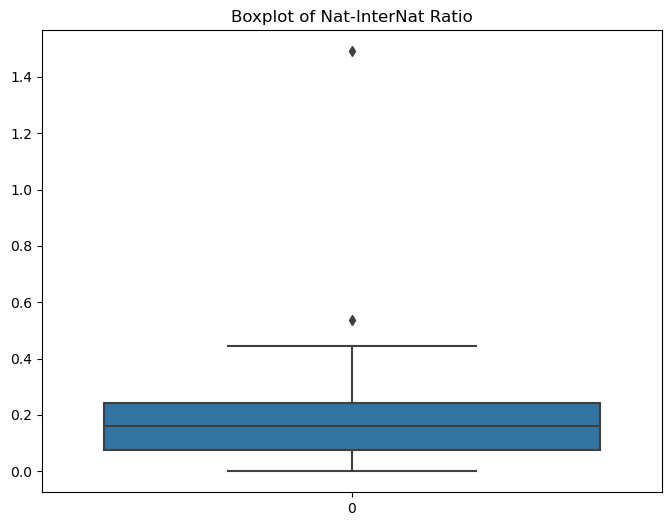

Outliers detected in column 'target':


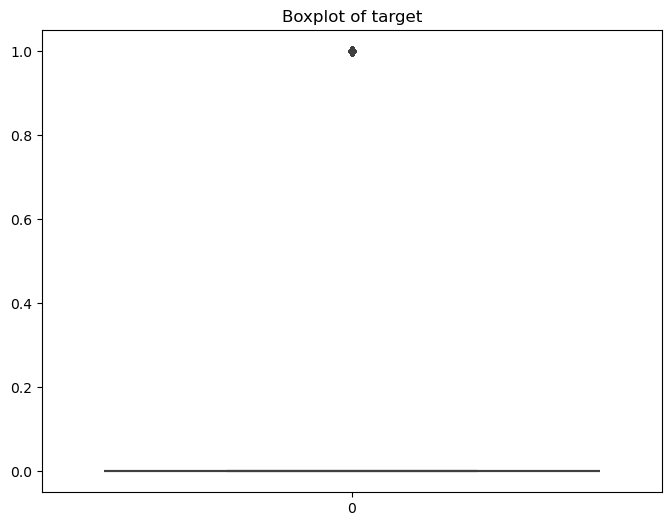

In [51]:
numerical_columns = validation.select_dtypes(include=['int64', 'float64']).columns

for column in numerical_columns:
    # Calculate 1st and 3rd quartiles
    q1 = validation[column].quantile(0.25)
    q3 = validation[column].quantile(0.75)
    
    # Calculate interquartile range (IQR)
    iqr = q3 - q1
    
    # Calculate lower and upper bounds for outliers
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Identify outliers
    outliers = validation[(validation[column] < lower_bound) | (validation[column] > upper_bound)]
    
    if not outliers.empty:
        print(f"Outliers detected in column '{column}':")
        #print(outliers)
    else:
        print(f"No outliers detected in column '{column}'")
    
    # Create boxplot to visualize distribution and outliers
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=validation[column])
    plt.title(f"Boxplot of {column}")
    plt.show()

In [52]:
# No duplicated values
dataset.duplicated().sum()

0

In [53]:
# Check for missing values
dataset.isnull().sum()

Gender                    0
Age                       0
Connect_Date              0
L_O_S                     0
Dropped_Calls             0
tariff                    0
Handset                   0
Peak_calls_Sum            0
Peak_mins_Sum             0
OffPeak_calls_Sum         0
OffPeak_mins_Sum          0
Weekend_calls_Sum         0
Weekend_mins_Sum          0
International_mins_Sum    0
Nat_call_cost_Sum         0
AvePeak                   0
AveOffPeak                0
AveWeekend                0
National_calls            0
National mins             0
AveNational               0
All_calls_mins            0
Dropped_calls_ratio       4
Usage_Band                4
Mins_charge               0
call_cost_per_min         4
actual call cost          0
Total_call_cost           0
Total_Cost                0
Tariff_OK                 0
average cost min          0
Peak ratio                0
OffPeak ratio             0
Weekend ratio             0
Nat-InterNat Ratio        0
high Dropped calls  

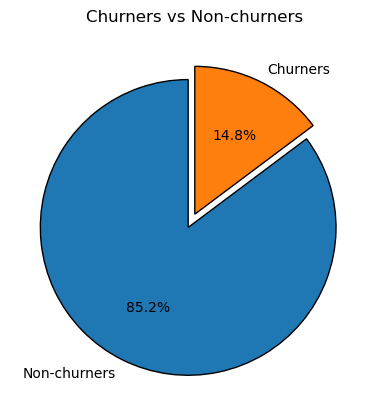

In [54]:
l = list(dataset['target'].value_counts())
circle = [l[0] / sum(l) * 100,l[1] / sum(l) * 100]

plt.pie(circle,labels = ['Non-churners','Churners'],autopct = '%1.1f%%',startangle = 90,explode = (0.1,0),
       wedgeprops = {'edgecolor' : 'black','linewidth': 1,'antialiased' : True})
plt.title('Churners vs Non-churners');

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'L_O_S'}>,
        <Axes: title={'center': 'Dropped_Calls'}>,
        <Axes: title={'center': 'Peak_calls_Sum'}>,
        <Axes: title={'center': 'Peak_mins_Sum'}>],
       [<Axes: title={'center': 'OffPeak_calls_Sum'}>,
        <Axes: title={'center': 'OffPeak_mins_Sum'}>,
        <Axes: title={'center': 'Weekend_calls_Sum'}>,
        <Axes: title={'center': 'Weekend_mins_Sum'}>,
        <Axes: title={'center': 'International_mins_Sum'}>],
       [<Axes: title={'center': 'Nat_call_cost_Sum'}>,
        <Axes: title={'center': 'AvePeak'}>,
        <Axes: title={'center': 'AveOffPeak'}>,
        <Axes: title={'center': 'AveWeekend'}>,
        <Axes: title={'center': 'National_calls'}>],
       [<Axes: title={'center': 'National mins'}>,
        <Axes: title={'center': 'AveNational'}>,
        <Axes: title={'center': 'All_calls_mins'}>,
        <Axes: title={'center': 'Dropped_calls_ratio'}>,
        <Axes: title={'c

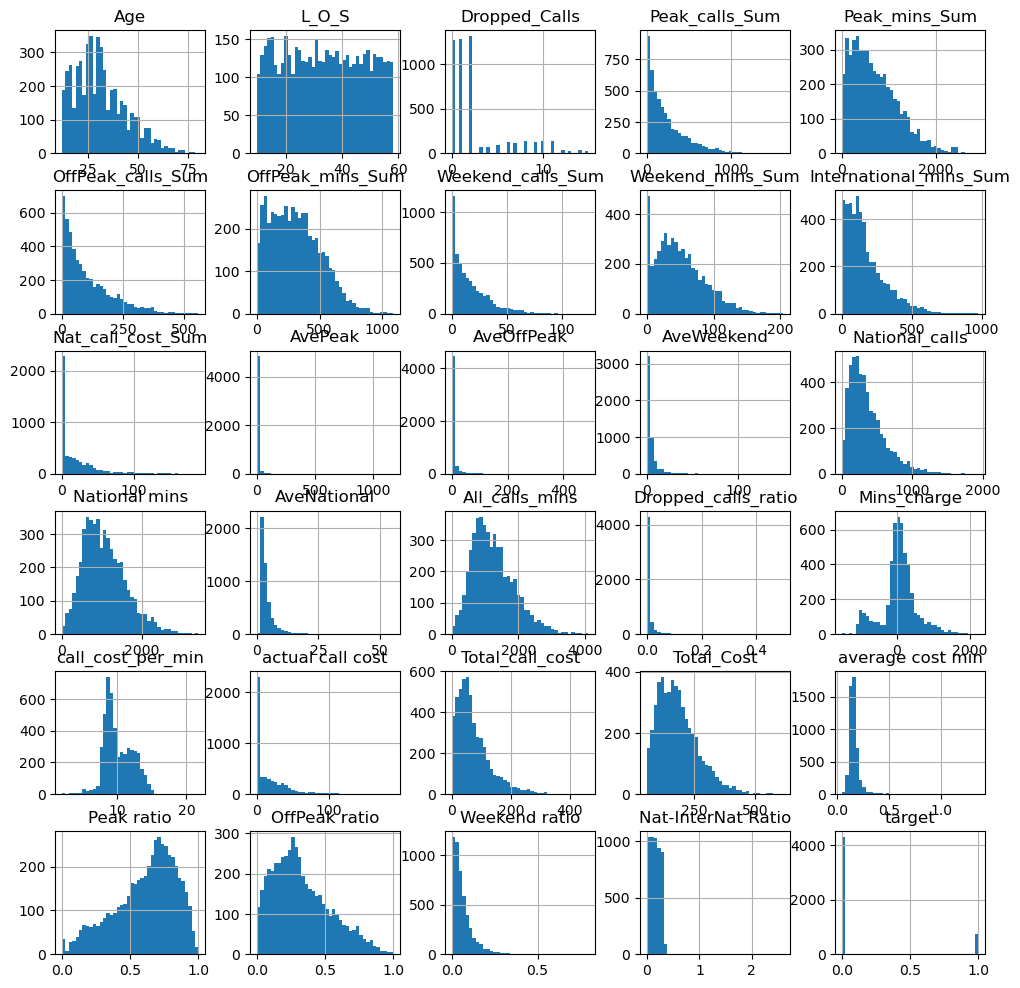

In [55]:
dataset.hist(bins=40, figsize=(12,12))

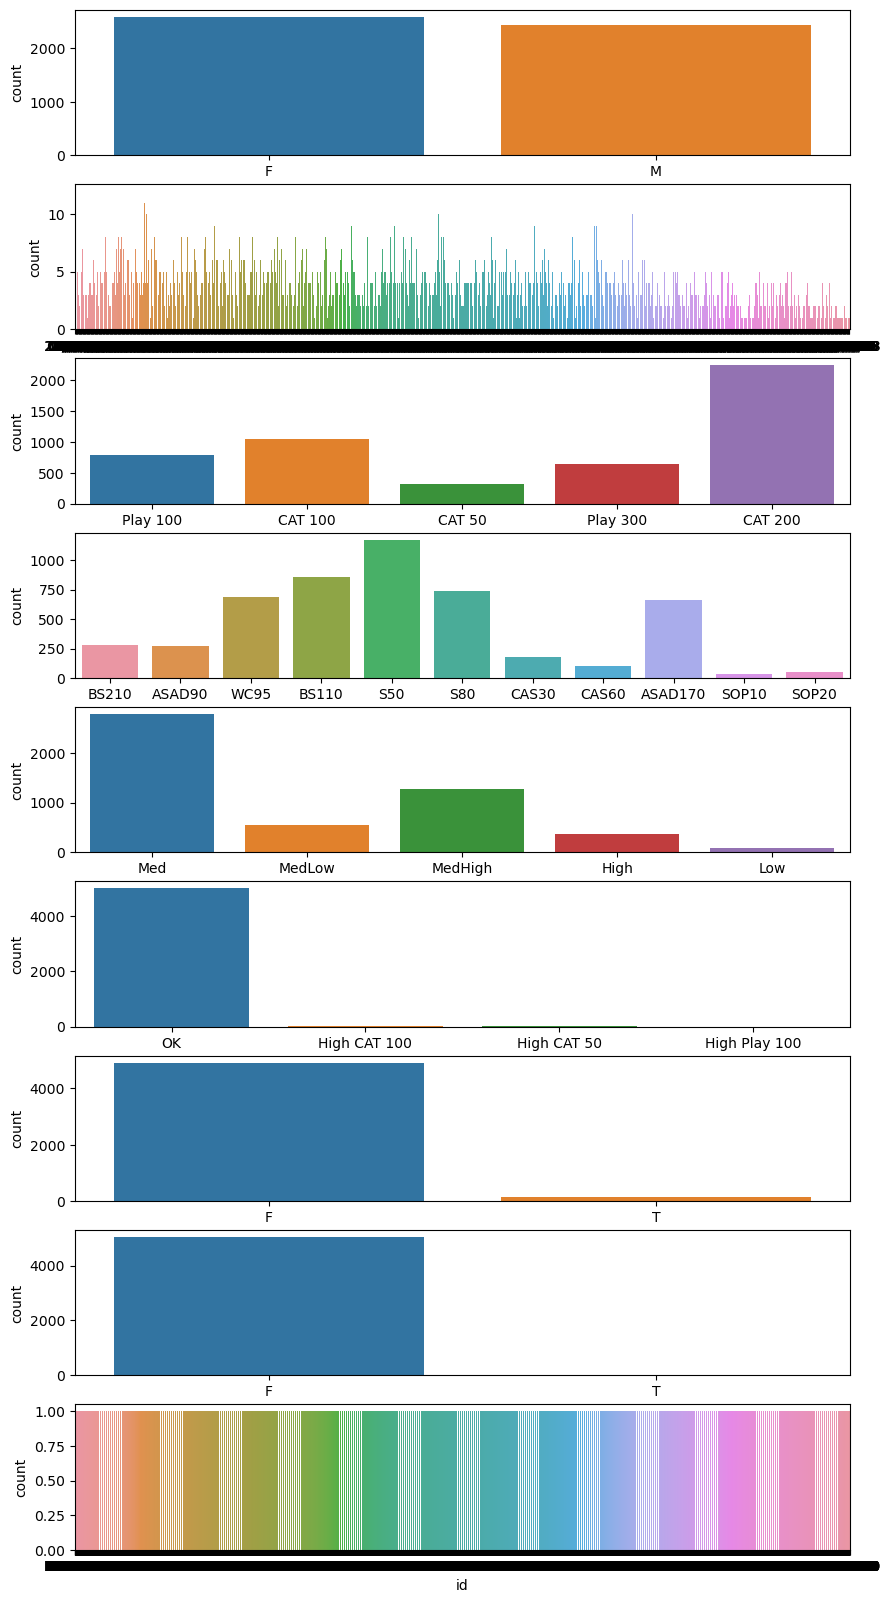

In [56]:
# Visualize categorical columns
cat_columns = dataset.select_dtypes('object').columns
fig, axs = plt.subplots(len(cat_columns), 1, figsize=(10,20))


for i, column in enumerate(cat_columns):
    sns.countplot(x = column, data = dataset, ax=axs[i])

In [57]:
cat_columns = dataset.select_dtypes('object').columns
dataset[cat_columns].nunique()

Gender                   2
Connect_Date          1349
tariff                   5
Handset                 11
Usage_Band               5
Tariff_OK                4
high Dropped calls       2
No Usage                 2
id                    5044
dtype: int64

### Data Preprocessing

In [58]:
# X contains the features and y the target variable
# Drop the unique identifier
X_train = dataset.drop(columns=['target','id'])
y_train = dataset['target']

train_X_encoder = dataset.drop(columns=['target','id'])
train_y_encoder = dataset['target']

X_test = validation.drop(columns=['target','id'])
y_test = validation['target']

### Training data

Replacing the NaN values

In [59]:
# Fill missing values only when 'No Usage' is False
# Apply transformations and explicitly call `infer_objects` to retain the old behavior
X_train.loc[X_train['No Usage'] == 'T', 'Dropped_calls_ratio'] = (
    X_train.loc[X_train['No Usage'] == 'T', 'Dropped_calls_ratio']
    .replace([pd.NA, np.NaN, 'NaN'], 0)
    .infer_objects(copy=False)
)
X_train.loc[X_train['No Usage'] == 'T', 'Usage_Band'] = (
    X_train.loc[X_train['No Usage'] == 'T', 'Usage_Band']
    .replace([pd.NA, np.NaN, 'NaN'], 0)
    .infer_objects(copy=False)
)
X_train.loc[X_train['No Usage'] == 'T', 'call_cost_per_min'] = (
    X_train.loc[X_train['No Usage'] == 'T', 'call_cost_per_min']
    .replace([pd.NA, np.NaN, 'NaN'], 0)
    .infer_objects(copy=False)
)

C:\Users\Romain\AppData\Local\Temp\ipykernel_10888\69542586.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train.loc[X_train['No Usage'] == 'T', 'Usage_Band']


Fix datetime feature

In [60]:
# Convert "Connect_Date" column to datetime
X_train["Connect_Date"] = pd.to_datetime(X_train["Connect_Date"], format='%d/%m/%y')

# Create a new column indicating whether the date falls on a weekend (Saturday or Sunday)
X_train["Day"] = (X_train["Connect_Date"].dt.dayofweek).astype(int)

X_train=X_train.drop('Connect_Date',axis=1)

Standardize numerical values

In [61]:
# Identify numerical columns
numerical_columns = X_train.select_dtypes(include=['int', 'float']).columns

scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])

Categorical transformation

In [62]:
# Categorical transformation

#1. WoE encoding maybe dummy encoding for gender and other which are a T or F
X_train['Handset'] = X_train['Handset'].astype('object')
X_train['Gender'] = X_train['Gender'].astype('object')
X_train['tariff'] = X_train['tariff'].astype('object')
X_train['Usage_Band'] = X_train['Usage_Band'].astype('object')
X_train['Tariff_OK'] = X_train['Tariff_OK'].astype('object')
X_train['high Dropped calls'] = X_train['high Dropped calls'].astype('object')
X_train['No Usage'] = X_train['No Usage'].astype('object')

# Instantiate the WoEEncoder
#'Handset',
woe = ce.WOEEncoder(cols=['Gender', 'tariff',  'Usage_Band', 'Tariff_OK', 'high Dropped calls', 'No Usage'])
ohe = ce.OneHotEncoder(cols=['Handset'],handle_unknown='indicator')
# Fit and transform the data
X_train = woe.fit_transform(X_train, y_train)
X_train = ohe.fit_transform(X_train, y_train)

Correlation analysis

C:\Users\Romain\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


<Figure size 640x480 with 0 Axes>

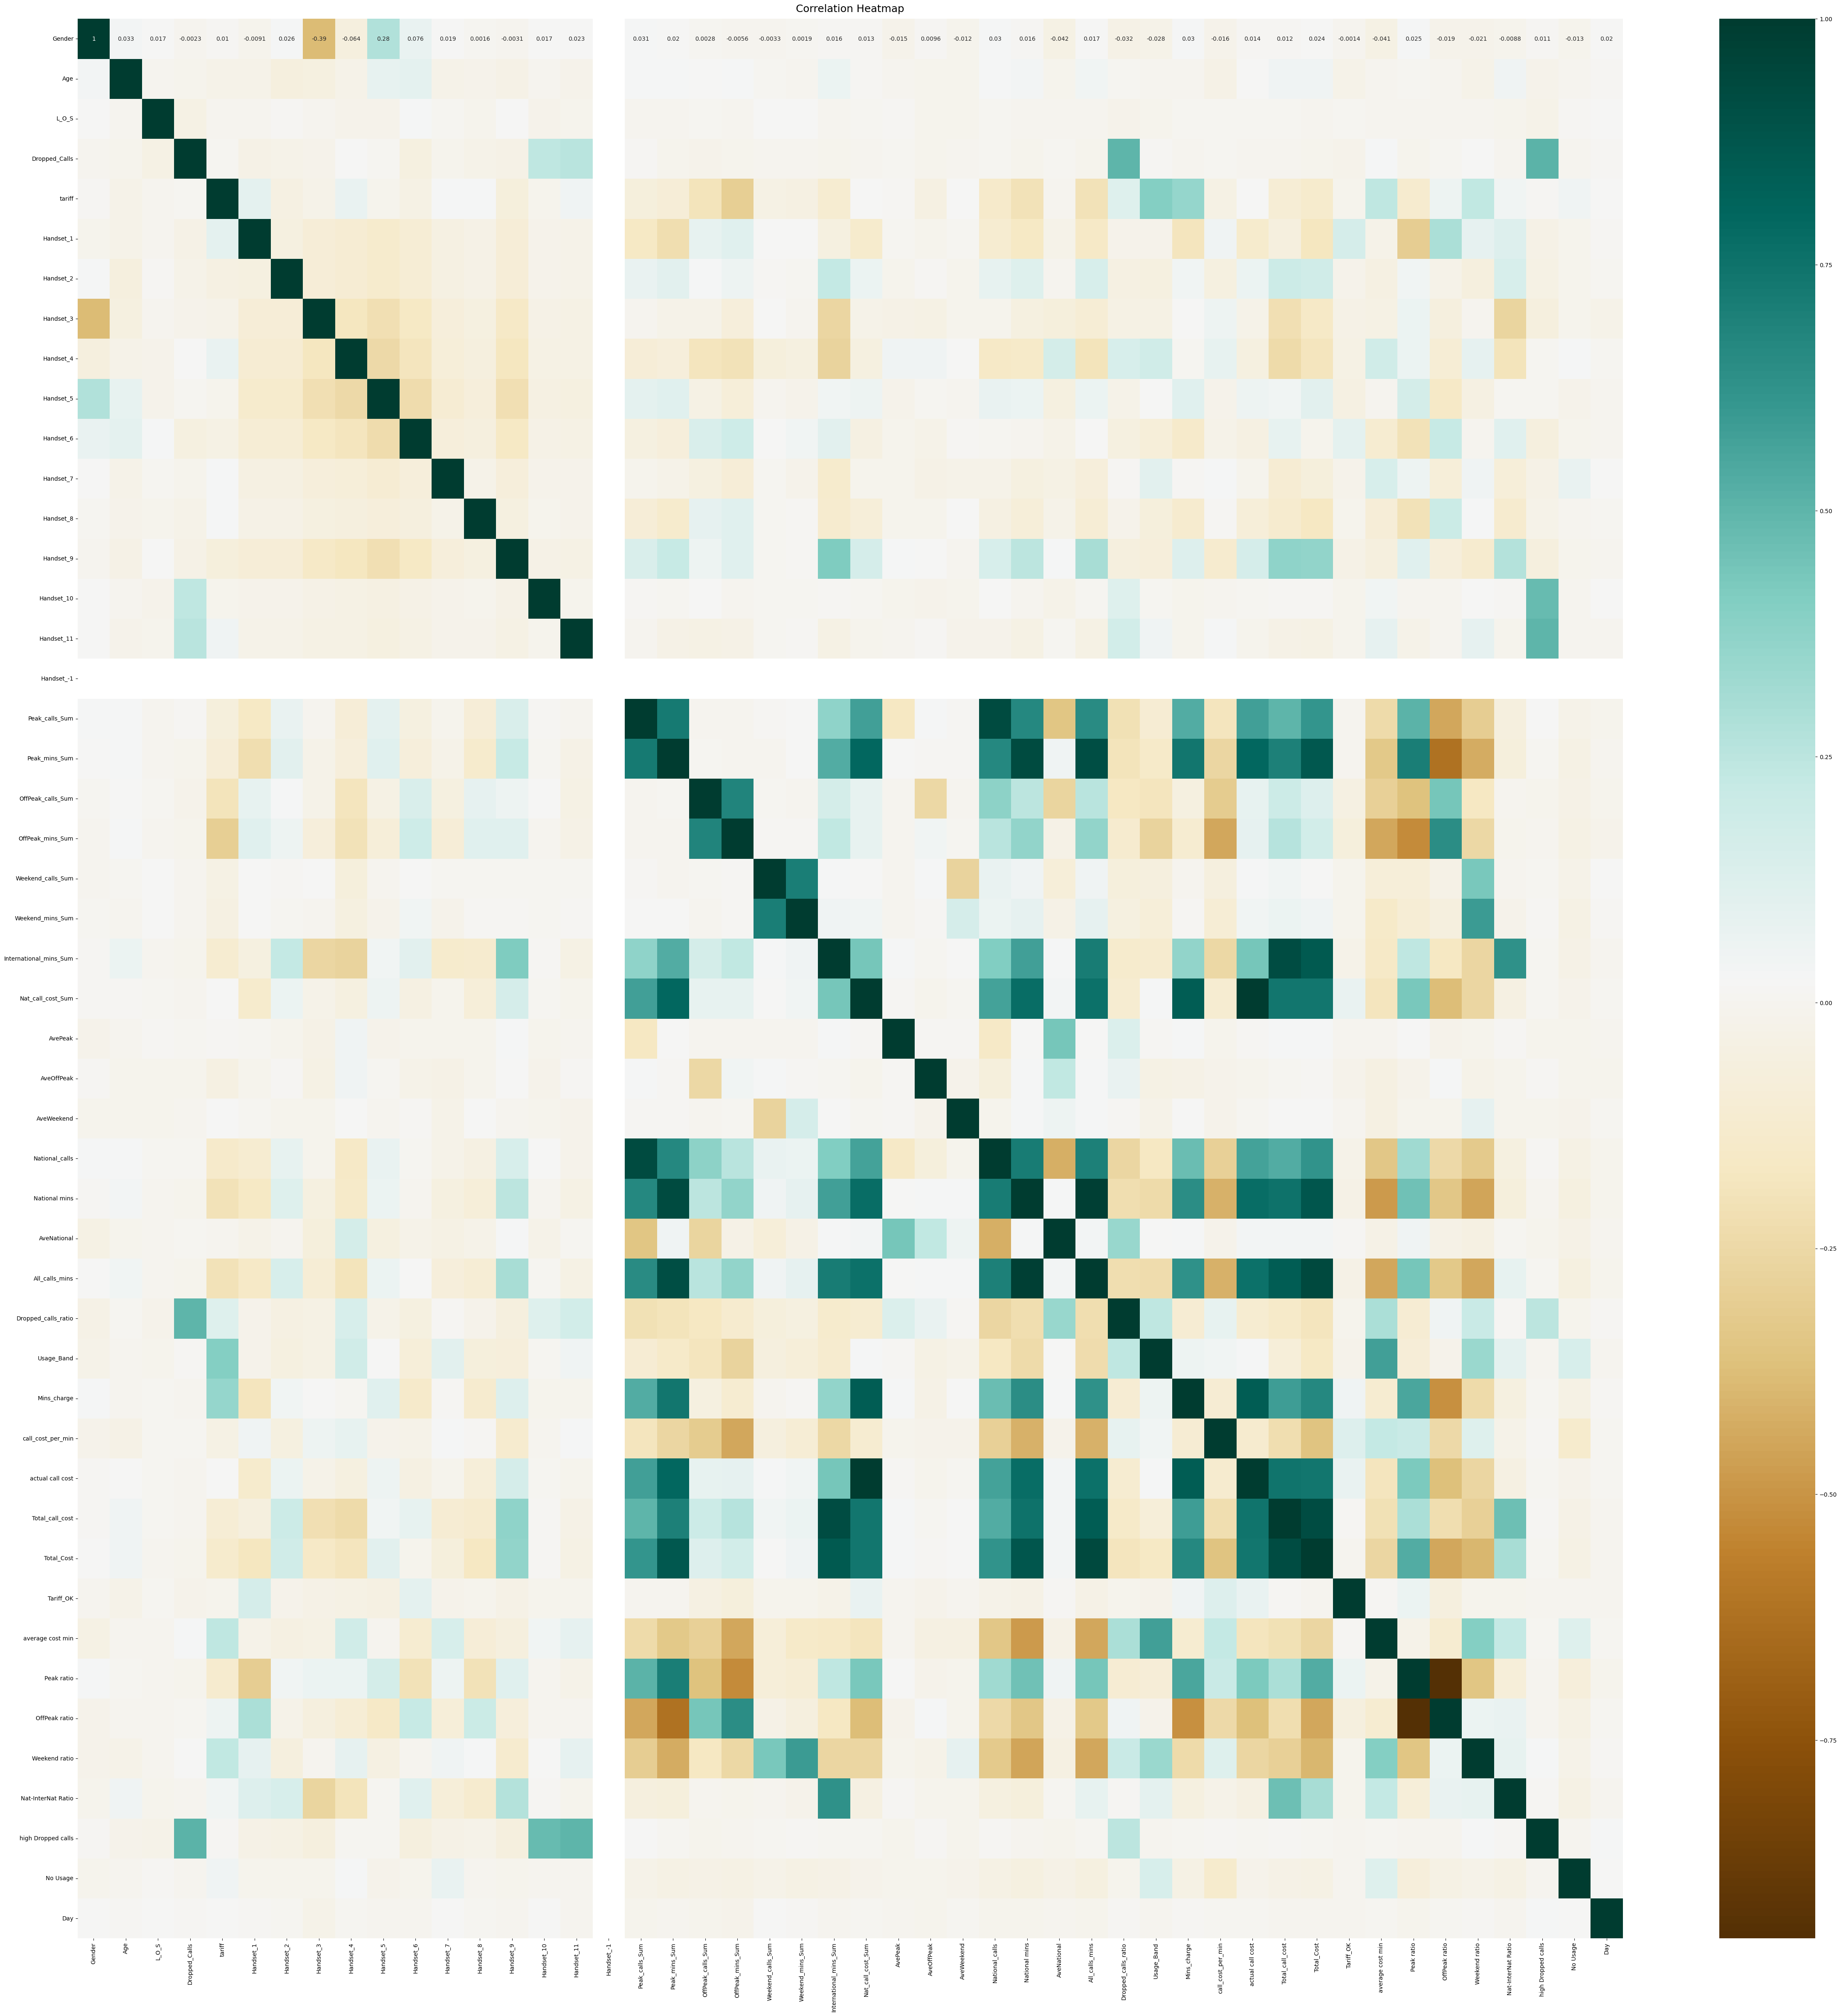

<Figure size 640x480 with 0 Axes>

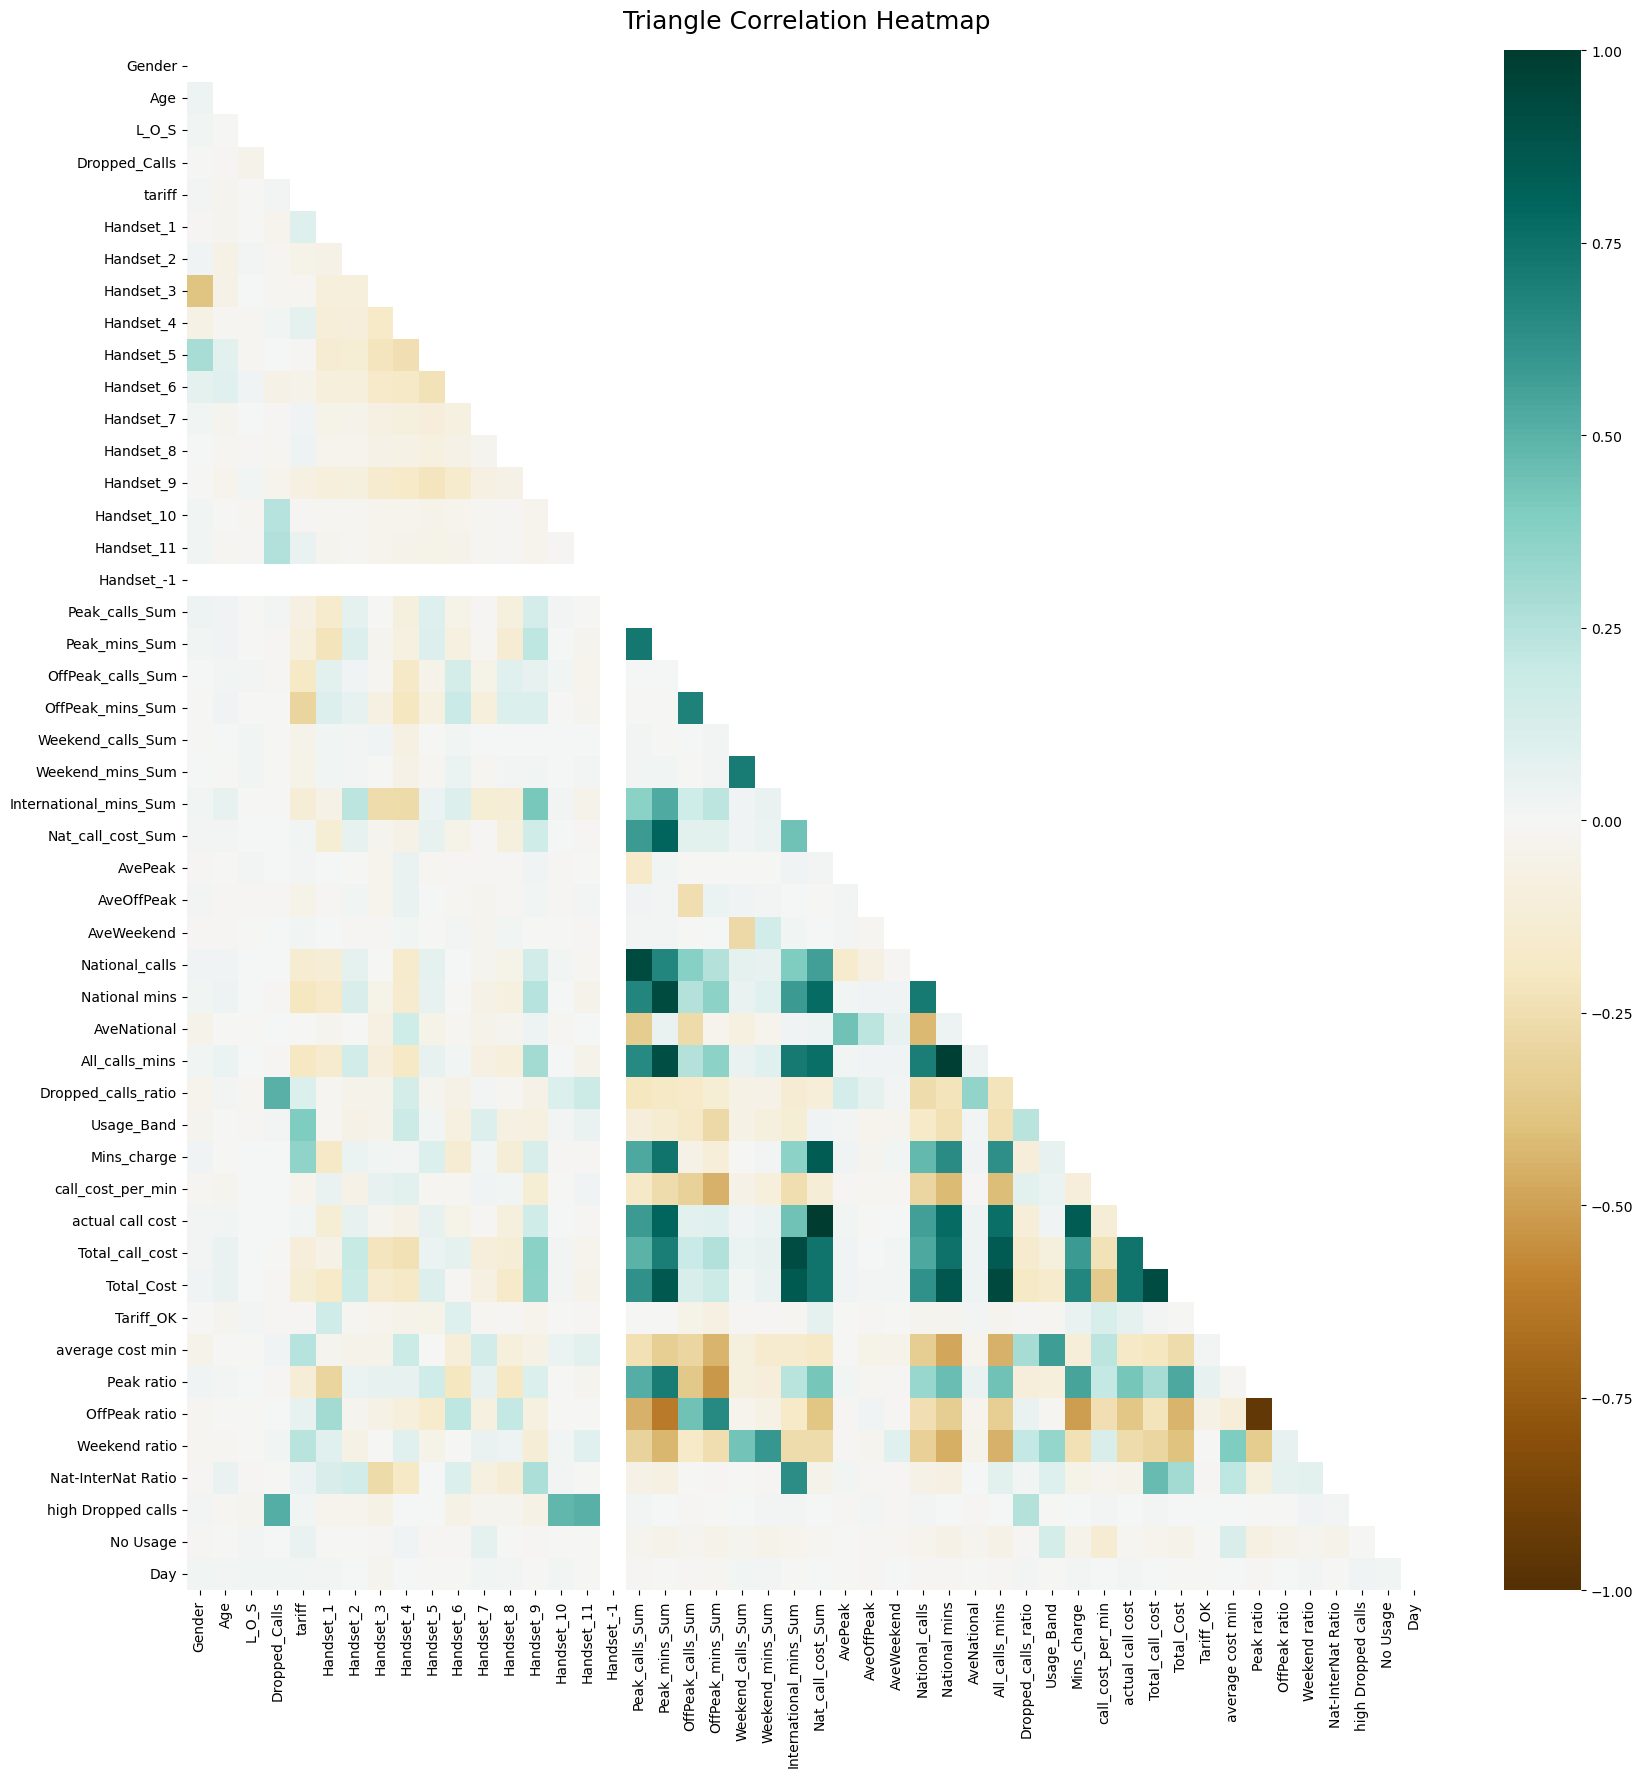

In [63]:
plt.figure()
plt.figure(figsize=(60, 60))
heatmap = sns.heatmap(X_train.corr(), annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
mask = np.triu(np.ones_like(X_train.corr(), dtype=bool))
plt.figure()
plt.figure(figsize=(20, 20))
heatmaptriangle = sns.heatmap(X_train.corr(), mask=mask, vmin=-1, vmax=1, annot=False, cmap='BrBG')
heatmaptriangle.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

C:\Users\Romain\anaconda3\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\Romain\anaconda3\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\Romain\anaconda3\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


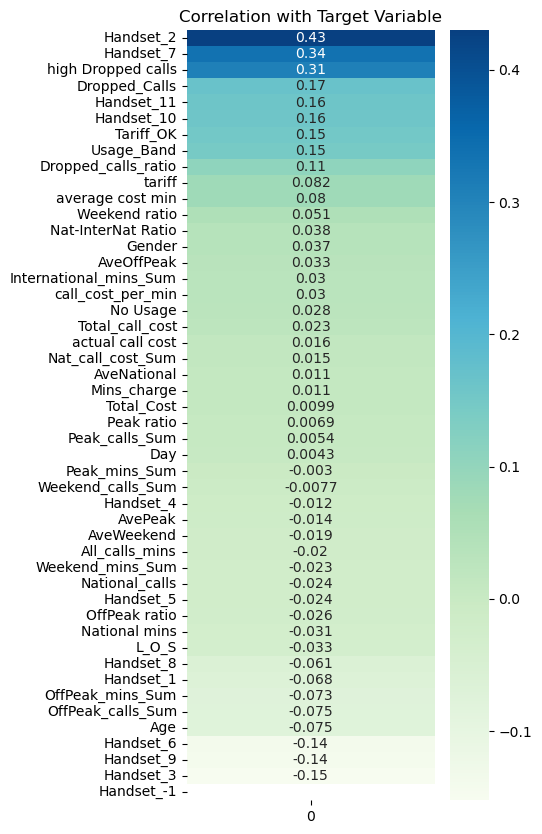

In [64]:
# Create a correlation matrix with target variable
corr_with_target = X_train[:-1].corrwith(y_train)

# Sort features by correlation with target variable
corr_with_target = corr_with_target.sort_values(ascending=False)

# Plot the heatmap
plt.figure(figsize=(4, 10))
sns.heatmap(corr_with_target.to_frame(), cmap='GnBu', annot=True)
plt.title('Correlation with Target Variable')
plt.show()

Feature importance with RF model

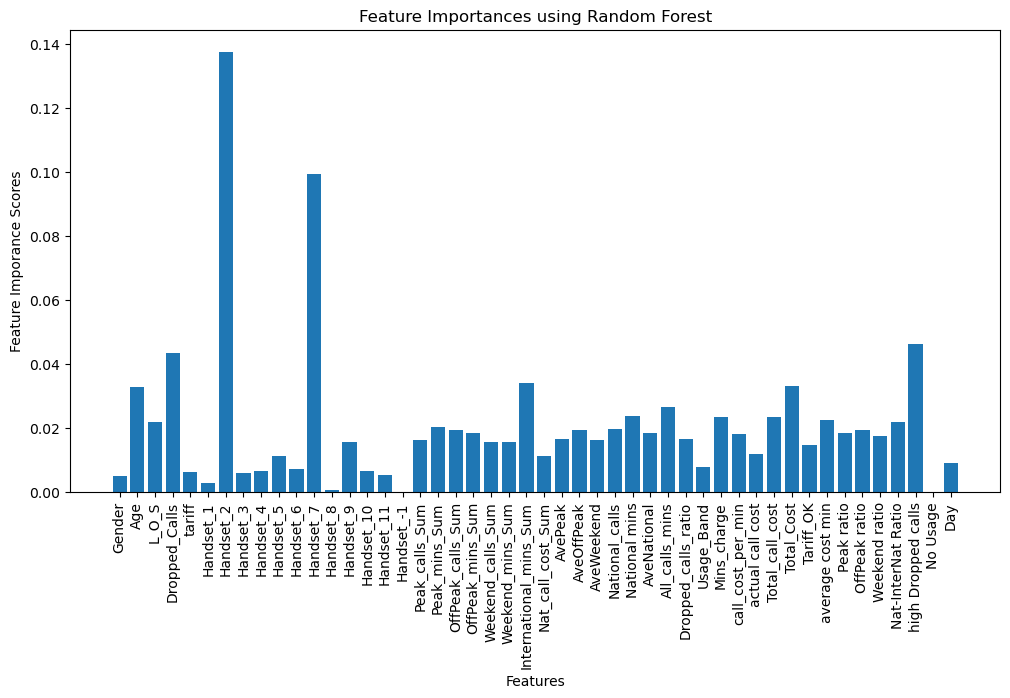

In [65]:
# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Visualize feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(X_train.shape[1]), importances)
plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
plt.ylabel('Feature Imporance Scores')
plt.xlabel('Features')
plt.title('Feature Importances using Random Forest')
plt.show()

Oversampling and undersampling

In [66]:
# Define the pipeline
X_encoder=X_train.copy()
y_encoder=y_train.copy()

pipeline = make_pipeline(
    ADASYN(sampling_strategy='minority'),  # ADASYN for oversampling minority class
    RandomUnderSampler(sampling_strategy='majority'),  # Random undersampling for majority class
)

# Apply the transformations to the training set
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train, y_train)

# Assigning weights to instances
# Weighting based on cost for churners
weights = np.ones(len(y_train_resampled))
# Filter the average cost min values for churners
churner_cost_min_values = X_train_resampled['average cost min'].values[y_train_resampled == 1]

# Calculate the maximum of average cost min for churners
churner_max_cost_min = churner_cost_min_values.max()

ratio = churner_cost_min_values / churner_max_cost_min

# Use np.where() to assign weights conditionally:
# If the ratio is negative, set weight to 1.
# Otherwise, calculate 1 + np.exp(ratio).
weights[y_train_resampled == 1] = np.where(
    ratio < 0,
    1, 
    1 + 2*np.exp(ratio)
)

Isolation Forest and Local Outlier Factor

In [67]:
# Step 1: Calculate Isolation Forest scores
iso_forest = IsolationForest(random_state=42)
iso_forest.fit(X_train_resampled)
iso_scores = iso_forest.decision_function(X_train_resampled)

# Step 2: Calculate LOF scores
lof = LocalOutlierFactor(n_neighbors=15, novelty=True)
lof.fit(X_train_resampled[y_train_resampled == 0]) 
lof_scores = lof.decision_function(X_train_resampled)

X_train_resampled['lof_score'] = lof_scores 
X_train_resampled['iso']=iso_scores

C:\Users\Romain\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


### Apply transformations to test

Missing values

In [68]:
# Replace Missing values
X_test['Dropped_calls_ratio'].fillna(0, inplace=True)
X_test['Usage_Band'].fillna(0, inplace=True)
X_test['call_cost_per_min'].fillna(0, inplace=True)

C:\Users\Romain\AppData\Local\Temp\ipykernel_10888\2431852406.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_test['Dropped_calls_ratio'].fillna(0, inplace=True)
C:\Users\Romain\AppData\Local\Temp\ipykernel_10888\2431852406.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.



Datetime features

In [69]:
# Transform Datetime
# Convert "Connect_Date" column to datetime
X_test["Connect_Date"] = pd.to_datetime(X_test["Connect_Date"], format='%d/%m/%y')

# Create a new column indicating whether the date falls on a weekend (Saturday or Sunday)
X_test["Day"] = (X_test["Connect_Date"].dt.dayofweek).astype(int)

X_test=X_test.drop('Connect_Date',axis=1)

Standardize

In [70]:
# Standardize numerical columns in the validation set
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

Categorical transformation

In [71]:
# Categorical transformation
X_test['Handset'] = X_test['Handset'].astype('object')
X_test['Gender'] = X_test['Gender'].astype('object')
X_test['tariff'] = X_test['tariff'].astype('object')
X_test['Usage_Band'] = X_test['Usage_Band'].astype('object')
X_test['Tariff_OK'] = X_test['Tariff_OK'].astype('object')
X_test['high Dropped calls'] = X_test['high Dropped calls'].astype('object')
X_test['No Usage'] = X_test['No Usage'].astype('object')

#1. WoE & Ohe encoding
X_test = woe.transform(X_test)
X_test = ohe.transform(X_test)

LOF and Isolation Forest

In [72]:
# Step 1: Apply Isolation Forest to the test dataset
iso_scores_test = iso_forest.decision_function(X_test)

# Step 2: Apply LOF to the test dataset
# Make sure `lof` model was trained on normal data and `novelty=True`
lof_scores_test = lof.decision_function(X_test)

X_test['lof_score'] = lof_scores_test
X_test['iso']=iso_scores_test

C:\Users\Romain\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


# Predictive

In [32]:
models=[]

Max profit with train_resampled

In [73]:
sorted_customers = X_train_resampled.sort_values(by='average cost min', ascending=False)

top20_churners = sorted_customers[y_train_resampled == 1].head(20)

max_average_cost_min = top20_churners['average cost min'].sum()
print("max_average_cost_min:", max_average_cost_min)

max_average_cost_min: 154.68850747295346


C:\Users\Romain\AppData\Local\Temp\ipykernel_10888\1588815020.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  top20_churners = sorted_customers[y_train_resampled == 1].head(20)


Scoring function

In [77]:
def top20_profit(clf,X, y_true):
    if hasattr(clf, 'predict_proba'):
        probabilities = clf.predict_proba(X)[:, 1]
    else:
        probabilities = clf.decision_function(X)
    
    df = pd.DataFrame({'average cost min':X['average cost min'],'probability': probabilities, 'labels': y_true})
    
    # Sort customers by probability in descending order
    sorted_customers = df.sort_values(by='probability', ascending=False)
    
    # Select the top 20 customers
    top_20_customers = sorted_customers.head(20)
    
    # Calculate the sum of average cost min for top 20 customers with label = 1
    sum_average_cost_min = top_20_customers[top_20_customers['labels'] == 1]['average cost min'].sum()
    
    # Return the sum of average cost min as the profit
    return sum_average_cost_min

# Define the scoring dictionary
scoring = {'roc_auc': 'roc_auc', 'top20_profit': top20_profit}

## Logistic regression

In [75]:
lambdas = [0.001, 0.01, 0.02, 0.03, 0.1, 0.2,0.3, 1, 5, 10, 15, 20]
#Define the 5-fold cross-validation procedure
kf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Lasso

In [78]:
#Define the logistic regression model with L1 regularization
log_reg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

#Define the grid search parameters
parameter_grid = {'C': [1/lambda_val for lambda_val in lambdas]}

#Define the GridSearchCV object
grid_search = GridSearchCV(estimator=log_reg, param_grid=parameter_grid, cv=kf5, scoring=scoring,refit='top20_profit')

# Perform the grid search to find the best C value based on the F1 scoring for Ridge
clf=grid_search.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

# Get the best model
logisticsLasso = clf.best_estimator_

models.append(logisticsLasso)
# Save the model to a file
model_filename = 'lasso_model_13_05_exp_strat_score.joblib'
dump(logisticsLasso, model_filename)
# Print the best C value (Lambda value) and corresponding F1 score for Ridge
print("Best C value (Lasso):", grid_search.best_params_['C'], ". Therefore best lambda: ", 1/grid_search.best_params_['C'])
print("Best average Precision score (Lasso):", grid_search.best_score_)

Best C value (Lasso): 0.05 . Therefore best lambda:  20.0
Best average Precision score (Lasso): 25.87974927157378


### Ridge

In [37]:
# Define the logistic regression model with L2 regularization (Ridge)
log_reg_ridge = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

# Define the grid search parameters for Ridge
parameter_grid_ridge = {'C': [1/lambda_val for lambda_val in lambdas]}

# Define the GridSearchCV object for Ridge
grid_search_ridge = GridSearchCV(estimator=log_reg_ridge, param_grid=parameter_grid_ridge, cv=kf5, scoring=scoring,refit='top20_profit')

# Perform the grid search to find the best C value based on the F1 scoring for Ridge
clf=grid_search_ridge.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

# Get the best model
logisticsRidge = clf.best_estimator_

models.append(logisticsRidge)
# Save the model to a file
model_filename = 'ridge_model_13_05.joblib'
dump(logisticsRidge, model_filename)
# Print the best C value (Lambda value) and corresponding F1 score for Ridge
print("Best C value (Ridge):", grid_search_ridge.best_params_['C'], ". Therefore best lambda: ", 1/grid_search_ridge.best_params_['C'])
print("Best average Precision score (Ridge):", grid_search_ridge.best_score_)

Best C value (Ridge): 0.05 . Therefore best lambda:  20.0
Best average Precision score (Ridge): 36.989582713636295


Elastic Net

In [79]:
# Define the logistic regression model with ElasticNet regularization
log_reg_elasticnet = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=1000)

# Define the grid search parameters for ElasticNet
parameter_grid_elasticnet = {'C': [1/lambda_val for lambda_val in lambdas], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}

# Define the GridSearchCV object for ElasticNet
grid_search_elasticnet = GridSearchCV(estimator=log_reg_elasticnet, param_grid=parameter_grid_elasticnet, cv=kf5, scoring=scoring,refit='top20_profit')

# Perform the grid search to find the best C value and l1_ratio based on the F1 scoring for ElasticNet
clf=grid_search_elasticnet.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

# Get the best model
logisticsElasticNet = clf.best_estimator_

models.append(logisticsElasticNet)

# Save the model to a file
model_filename = 'elasticnet_model_13_05.joblib'
dump(logisticsElasticNet, model_filename)

print(f'Model saved to {model_filename}')
# Print the best C value (Lambda value), best l1_ratio, and corresponding F1 score for ElasticNet
print("Best C value (ElasticNet):", grid_search_elasticnet.best_params_['C'], ". Therefore best lambda: ", 1/grid_search_elasticnet.best_params_['C'])
print("Best l1_ratio:", grid_search_elasticnet.best_params_['l1_ratio'])
print("Best average Precision score (ElasticNet):", grid_search_elasticnet.best_score_)

C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Romain\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max

Model saved to elasticnet_model_13_05.joblib
Best C value (ElasticNet): 0.05 . Therefore best lambda:  20.0
Best l1_ratio: 0.1
Best average Precision score (ElasticNet): 39.25931013485124


## Random Forest

In [53]:
# Random Forest
clf = RandomForestClassifier(
    min_weight_fraction_leaf=0.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced')

param_grid = {
    'min_samples_leaf': [1,2,3,4,5],
    'min_samples_split': [1,2,3,4,5,10],
    'n_estimators': [100,200,300,400,500,600,700,800,900,1000],
    'max_features': [None, 'sqrt'],
    'max_depth' : [5, 10,20,30,40,50,60,70,80,90,100, None]
}

CV_clf = RandomizedSearchCV(clf,param_grid, n_jobs=5, cv=kf5, verbose=2, scoring=scoring,refit='top20_profit')
CV_clf.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

# Get the best model
rf_model_best = CV_clf.best_estimator_

print("Best average AUC score (Random Forest):", CV_clf.best_score_)
models.append(rf_model_best)

# Save the model to a file
model_filename = 'random_forest_model_13_05_1.joblib'
dump(rf_model_best, model_filename)

print(f'Model saved to {model_filename}')


Fitting 5 folds for each of 10 candidates, totalling 50 fits


KeyboardInterrupt: 

## XGBoost

Create custom loss function for XGBoost

In [58]:
# Define the parameter grid
params = {
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'learning_rate': [0.001, 0.01, 0.1, 0.20, 0.25, 0.30],
    'gamma': [0, 0.25, 0.5, 0.75, 1],
    'n_estimators': [50,100,200,300,400, 500, 1000],
    'min_child_weight':[1,2,3,4,5,10],
    'subsample':[0.4,0.6,0.8,1],
    'colsample_bytree':[0.4,0.6,0.8,1],
    'reg_lambda':[0,1,2,3,4,5,10]
}

# Define the K-Fold cross-validation
#kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

# Create the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42)


# Set up the GridSearchCV with the XGBoost model and parameters
clf = RandomizedSearchCV(xgb_model, params, n_iter=250,n_jobs=5, cv=kf5, verbose=3, scoring=scoring,refit='top20_profit')

# Fit the model
clf.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

# Get the best model
xgb_model_best = clf.best_estimator_
print("Best average AUC score (Random Forest):", clf.best_score_)

# Save the model to a file
model_filename = 'xgb_model_auc_13_05_4.joblib'
dump(xgb_model_best, model_filename)

print(f'Model saved to {model_filename}')
models.append(xgb_model_best)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
Best average AUC score (Random Forest): 54.76061970827131
Model saved to xgb_model_auc_13_05_4.joblib


## LightGBM

In [ ]:
# Define the LightGBM classifier
lgb_model = lgb.LGBMClassifier(random_state=42)

# Define the parameter grid
params = {
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'learning_rate': [0.001, 0.01, 0.1, 0.20, 0.25, 0.30],
    'gamma': [0, 0.25, 0.5, 0.75, 1],
    'n_estimators': [100, 500, 1000]
}

# Define the K-Fold cross-validation
kf5 = KFold(n_splits=5, shuffle=True, random_state=42)

# Set up the GridSearchCV with the LightGBM model and parameters
clf = RandomSeacrhCV(lgb_model, params, n_jobs=5, cv=kf5, verbose=2, scoring=scoring,refit='top20_profit')

# Fit the model
clf.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

# Get the best model
lgb_model_best = clf.best_estimator_

# Print the best average AUC score
print("Best average AUC score (LightGBM):", clf.best_score_)

models.append(lgb_model_best)

# Save the model to a file
model_filename = 'lgb_model_3_05_f1.joblib'
dump(lgb_model_best, model_filename)

print(f'Model saved to {model_filename}')

### Catboost

In [ ]:
# Define the CatBoost classifier
cb_model = CatBoostClassifier(random_state=42, silent=True)

# Define the parameter grid
params = {
    'depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'learning_rate': [0.001, 0.01, 0.1, 0.20, 0.25, 0.30],
    'l2_leaf_reg': [0, 0.25, 0.5, 0.75, 1],
    'iterations': [100, 500, 1000]
}

# Set up the GridSearchCV with the CatBoost model and parameters
clf = RandomSearchCV(cb_model, params, n_jobs=5, cv=kf5, verbose=2, scoring=scoring,refit='top20_profit')

# Fit the model
clf.fit(X_train_resampled, y_train_resampled, sample_weight=weights)

# Get the best model
cb_model_best = clf.best_estimator_

# Print the best average AUC score
print("Best average AUC score (CatBoost):", clf.best_score_)

models.append(cb_model_best)

# Evaluation of algorithms

## ROC Curves and AUC

In [39]:
def plot_roc_curves(models, X_test, y_test, model_names=None):
    plt.figure(figsize=(10, 8))

    # Plot ROC curve for each model
    for i, model in enumerate(models):
        if 'probability' in X_test.columns:
          X_test = X_test.drop(columns=['probability'])
        # Predict probabilities
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)

        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        model_name = model_names[i] if model_names else f"Model {i+1}"
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

    # Plot the diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    # Add labels and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend(loc='lower right')

    # Display the plot
    plt.show()

def evaluate_models(models, X_test, y_test):
    # Initialize a list to hold the evaluation results
    results = []

    # Loop through each model in the list of models
    for model in models:
        if 'probability' in X_test.columns:
          X_test = X_test.drop(columns=['probability'])
        if 'labels' in X_test.columns:
          X_test = X_test.drop(columns=['labels'])
        # Make predictions (probabilities) for the test dataset
        probabilities = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        X_test['probability'] = probabilities

        # Calculate the AUC score
        auc_score = roc_auc_score(y_test, X_test['probability'])
        test = X_test.copy()
        test['labels']=y_test
        
        # Sort customers based on predicted probabilities in ascending order
        sorted_customers = test.sort_values(by='probability', ascending=False)
        
        # Select the top 20 customers with the lowest probability of churning
        top_20_customers = sorted_customers.head(20)

        # Calculate the sum of 'average cost min' for the top 20 customers
        # Calculate the sum of 'average cost min' for the rows where 'label' = 1
        sum_average_cost_min = top_20_customers[top_20_customers['labels'] == 1]['average cost min'].sum()


        # Append the model's name, AUC score, and sum of 'average cost min' to the results list
        results.append({
            'Model': model.__class__.__name__,
            'AUC Score': auc_score,
            'Sum of "average cost min" for top 20 customers': sum_average_cost_min
        })
        if 'probability' in X_test.columns:
          X_test = X_test.drop(columns=['probability'])
        if 'labels' in X_test.columns:
          X_test = X_test.drop(columns=['labels'])

    # Convert the results list to a Pandas DataFrame
    results_df = pd.DataFrame(results)

    # Sort the results DataFrame in descending order of the sum of 'average cost min' for the top 20 customers
    results_df.sort_values(by='Sum of "average cost min" for top 20 customers', ascending=False, inplace=True)

    # Print the results in a tabular manner
    display(results_df)

    # Return the sorted DataFrame
    return results_df


Load saved models

In [94]:
models=[]
directory = r'C:\Users\Romain\OneDrive - KU Leuven\Masters\MBIS\Year 1\Semester 2\Big Data Platforms and Technologies'  # Replace with the actual directory path
# Iterate through all files in the directory
for filename in os.listdir(directory):
    # Check if the file is a .joblib file and contains '7_05' in its name
    if filename.endswith('.joblib') and '13_05' in filename and not filename.startswith('xgb'):
        # Create the full path to the file
        file_path = os.path.join(directory, filename)
        
        # Load the model from the file
        model = load(file_path)
        
        # Append the loaded model to the list of models
        models.append(model)
        
        # Print a success message
        print(f'Model loaded successfully: {filename}')

Model loaded successfully: best_model_xgb_13_05.joblib
Model loaded successfully: elasticnet_model_13_05.joblib
Model loaded successfully: lasso_model_13_05_exp_strat_score.joblib
Model loaded successfully: random_forest_model_13_05.joblib
Model loaded successfully: ridge_model_13_05.joblib


,Model,AUC Score,"Sum of ""average cost min"" for top 20 customers"
0,XGBClassifier,0.871080,56.651777
1,LogisticRegression,0.918182,45.097599
4,LogisticRegression,0.917566,45.097599
3,RandomForestClassifier,0.881105,32.997276
2,LogisticRegression,0.926688,24.749701


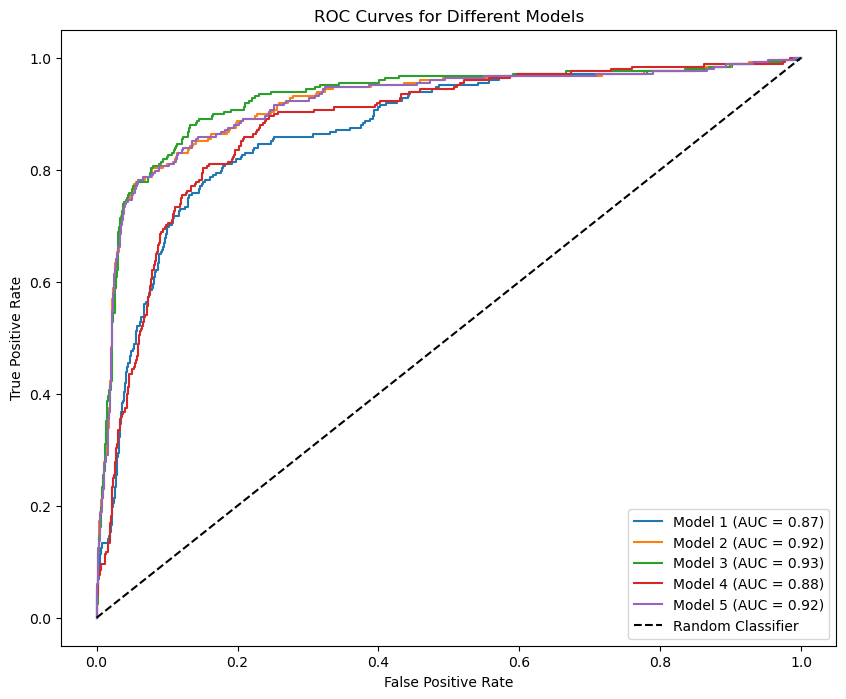

In [95]:
results_df=evaluate_models(models, X_test, y_test)
plot_roc_curves(models, X_test, y_test)

In [108]:
models

[XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.4, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=0.25, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.001, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=4, max_leaves=None,
               min_child_weight=4, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=300, n_jobs=None,
               num_parallel_tree=None, random_state=42, ...),
 LogisticRegression(C=0.05, l1_ratio=0.1, max_iter=1000, penalty='elasticnet',
                    solver='saga'),
 LogisticRegression(C=0.05, max_iter=1000, penalty='l1', solver='liblinear'),
 RandomForestClassifier(class_weight='balanced

In [61]:
# Load the model from the file
best_model=models[3]
instance_ids = test['id']
test=test.drop('id',axis=1)

# Replace Missing values
test['Dropped_calls_ratio'].fillna(0, inplace=True)
test['Usage_Band'].fillna(0, inplace=True)
test['call_cost_per_min'].fillna(0, inplace=True)

# Transform Datetime
# Convert "Connect_Date" column to datetime
test["Connect_Date"] = pd.to_datetime(test["Connect_Date"], format='%d/%m/%y')

# Create a new column indicating which day of the week it is
test["Day"] = (test["Connect_Date"].dt.dayofweek).astype(int)

test=test.drop('Connect_Date',axis=1)

# Standardize numerical columns in the validation set
test[numerical_columns] = scaler.transform(test[numerical_columns])

# Categorical transformation
test['Handset'] = test['Handset'].astype('object')
test['Gender'] = test['Gender'].astype('object')
test['tariff'] = test['tariff'].astype('object')
test['Usage_Band'] = test['Usage_Band'].astype('object')
test['Tariff_OK'] = test['Tariff_OK'].astype('object')
test['high Dropped calls'] = test['high Dropped calls'].astype('object')
test['No Usage'] = test['No Usage'].astype('object')

#1. WoE & Ohe encoding
test = woe.transform(test)
test = ohe.transform(test)

# Step 1: Apply Isolation Forest to the test dataset
iso_scores_test_pred = iso_forest.decision_function(test)

# Step 2: Apply LOF to the test dataset
# Make sure `lof` model was trained on normal data and `novelty=True`
lof_scores_test_pred = lof.decision_function(test)

test['lof_score'] = lof_scores_test_pred
test['iso']=iso_scores_test_pred

predictions = best_model.predict_proba(test)[:, 1]

print(predictions)
print(predictions.min())
data = {
    'ID': instance_ids,
    'PRED': predictions
}

df = pd.DataFrame(data)
display(df)
csv_file_path = 'predictions_xgb_3.csv'
df.to_csv(csv_file_path, index=False)

print(f"Predictions have been saved to {csv_file_path}")

C:\Users\Romain\AppData\Local\Temp\ipykernel_20632\3717031325.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test['Dropped_calls_ratio'].fillna(0, inplace=True)
C:\Users\Romain\AppData\Local\Temp\ipykernel_20632\3717031325.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

[0.59944266 0.6105146  0.6003215  ... 0.6114436  0.63743544 0.59944266]
0.5976468


,ID,PRED
0,K751808,0.599443
1,K837351,0.610515
2,K548114,0.600321
3,K736156,0.599443
4,K508080,0.599666
...,...,...
1677,K588314,0.611270
1678,K826807,0.616831
1679,K982731,0.611444
1680,K623037,0.637435


Predictions have been saved to predictions_xgb_3.csv


## Model Interpretation

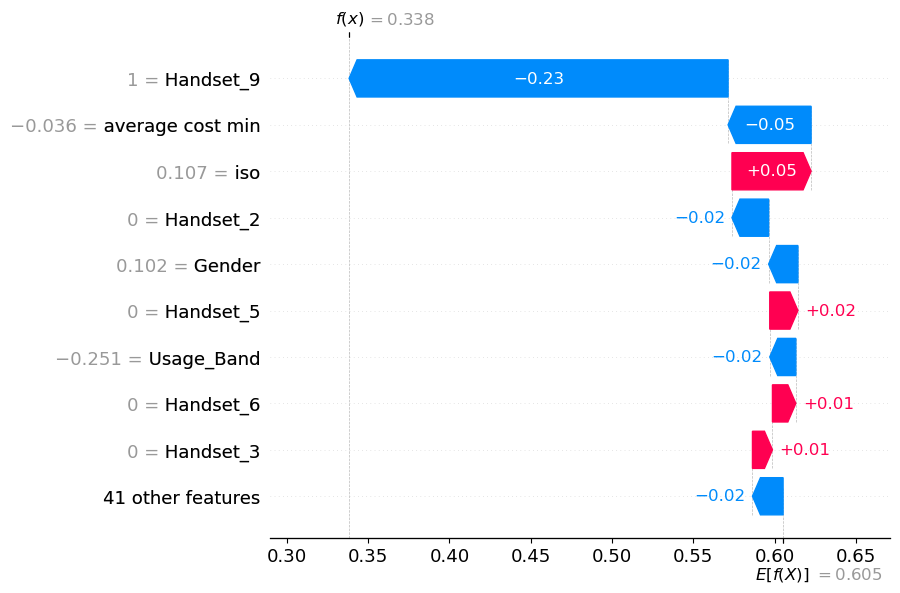

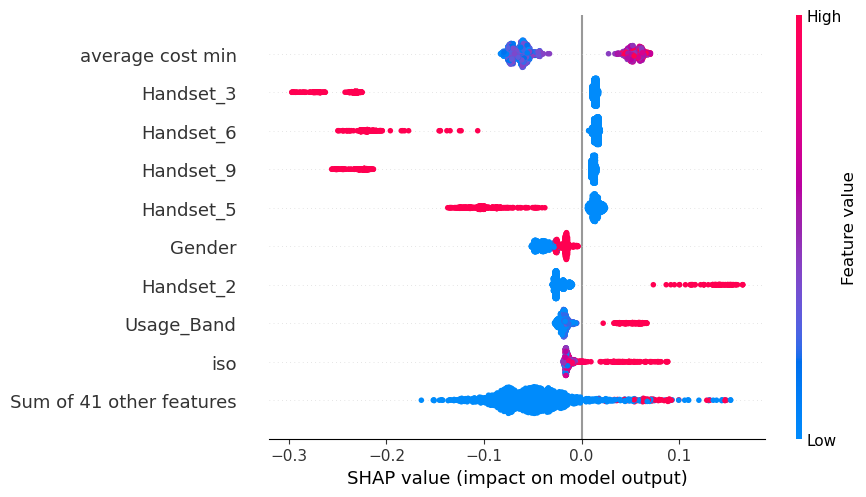

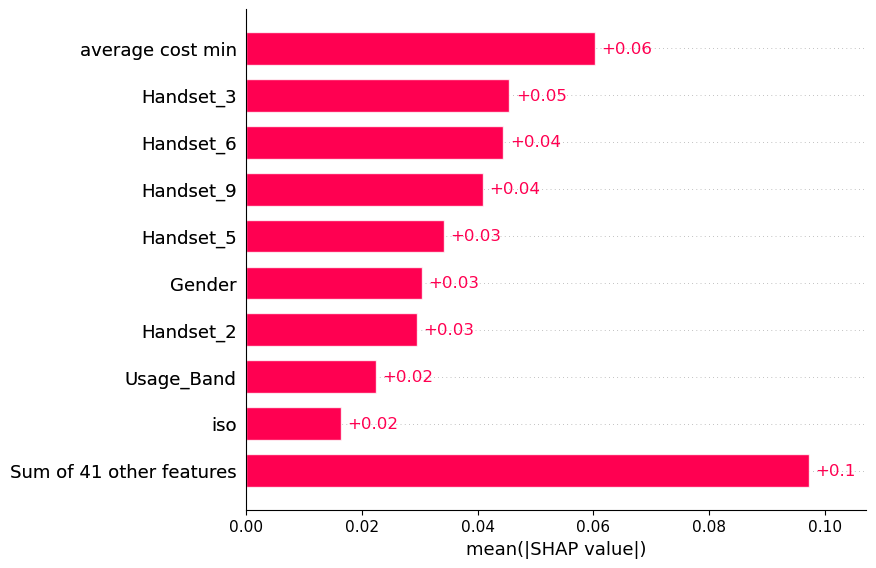

In [87]:
model = load("best_model_xgb_13_05.joblib")
X_test = X_test.drop(columns=['probability'])
explainer=shap.Explainer(model)
shap_values=explainer(X_test)

#shap.summary_plot(shap_values, X_test)
shap.plots.waterfall(shap_values[1])
shap.initjs()
shap.plots.force(shap_values[0])
#shap.plots.force(shap_values[1])
#shap.plots.force(shap_values[:500])
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)
#shap.plots.scatter(shap_values[:, "Handset_9"], color=shap_values)

Test for anomaly detection using variational autoencoder

In [107]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.losses import MeanSquaredError
from sklearn.preprocessing import StandardScaler,Normalizer, MinMaxScaler

mask = y_encoder == 0
X_encoder=X_encoder[mask]
y_encoder=y_encoder[mask]

train_X_encoder, val_X_encoder,train_y_encoder, val_y_encoder = train_test_split(X_encoder,y_encoder,test_size=0.2)

pipeline_norm_scaler = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])

pipeline_norm_scaler.fit(train_X_encoder)
train_X_encoder = pipeline_norm_scaler.transform(train_X_encoder)

val_X_encoder = pipeline_norm_scaler.transform(val_X_encoder)

class VAE(Model):
    def __init__(self, latent_dim=2, input_dim=None, dropout_rate=0.5):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate
        self.encoder = self.build_encoder(latent_dim, input_dim)
        self.decoder = self.build_decoder(latent_dim, input_dim)

    def build_encoder(self, latent_dim, input_dim):
        model = tf.keras.Sequential([
            layers.Dense(256, activation='elu'),
            layers.BatchNormalization(),  # Add batch normalization
            layers.Dropout(self.dropout_rate),  # Add dropout
            
            layers.Dense(128, activation='elu'),
            layers.BatchNormalization(),  # Add batch normalization
            layers.Dropout(self.dropout_rate),  # Add dropout
            
            layers.Dense(64, activation='elu'),
            layers.BatchNormalization(),  # Add batch normalization
            layers.Dropout(self.dropout_rate),  # Add dropout
            
            layers.Dense(32, activation='elu'),
            layers.BatchNormalization(),  # Add batch normalization
            layers.Dropout(self.dropout_rate),  # Add dropout
            
            layers.Dense(latent_dim * 2)  # For the mean and log variance
        ])
        return model

    def build_decoder(self, latent_dim, input_dim):
        model = tf.keras.Sequential([
            layers.Dense(32, activation='elu'),
            layers.BatchNormalization(),  # Add batch normalization
            layers.Dropout(self.dropout_rate),  # Add dropout
            
            layers.Dense(64, activation='elu'),
            layers.BatchNormalization(),  # Add batch normalization
            layers.Dropout(self.dropout_rate),  # Add dropout
            
            layers.Dense(128, activation='elu'),
            layers.BatchNormalization(),  # Add batch normalization
            layers.Dropout(self.dropout_rate),  # Add dropout
            
            layers.Dense(256, activation='elu'),
            layers.BatchNormalization(),  # Add batch normalization
            layers.Dropout(self.dropout_rate),  # Add dropout
            
            layers.Dense(input_dim, activation='linear') #tanh?
        ])
        return model

    def encode(self, x):
        # Get the mean and log variance from the encoder
        mean_logvar = self.encoder(x)
        mean = mean_logvar[:, :self.latent_dim]
        logvar = mean_logvar[:, self.latent_dim:]
        return mean, logvar

    def reparameterize(self, mean, logvar):
        epsilon = tf.random.normal(tf.shape(logvar))
        z = mean + tf.exp(0.5 * logvar) * epsilon
        return z

    def decode(self, z):
        return self.decoder(z)

    def call(self, inputs):
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mean, logvar


# Define the loss function wrapper
mse = MeanSquaredError()

def vae_loss_fn(y_true, y_pred, mean, logvar):
    # Compute reconstruction loss
    reconstruction_loss = mse(y_true, y_pred)

    # Compute KL divergence
    kl_divergence = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))

    return reconstruction_loss + kl_divergence


# Initialize the VAE model
input_dim = train_X_encoder.shape[1]
latent_dim = 8 
vae = VAE(latent_dim=latent_dim, input_dim=input_dim)

# Define the model with inputs and outputs
inputs = tf.keras.Input(shape=(input_dim,))
outputs, mean, logvar = vae(inputs)
model = Model(inputs=inputs, outputs=[outputs, mean, logvar])

@tf.function
def loss_fn(y_true, outputs):
    # Access the outputs using indexing
    y_pred = outputs[0]
    mean = outputs[1]
    logvar = outputs[2]

    # Calculate the VAE loss using the vae_loss_fn
    return vae_loss_fn(y_true, y_pred, mean, logvar)

model.compile(optimizer='adam', loss=loss_fn)

cb = tf.keras.callbacks.ModelCheckpoint(
    filepath='autoencoder_best_weights.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=0,
    mode='min'
)
history = model.fit(train_X_encoder, 
                    train_X_encoder, 
                    epochs=100, 
                    batch_size=256,
                    shuffle=True,
                    callbacks=cb,
                    validation_data=(val_X_encoder, val_X_encoder))

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - loss: 7.5681 - val_loss: 0.2421
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 5.3354 - val_loss: 0.2627
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 5.0637 - val_loss: 0.2747
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 7.6040 - val_loss: 0.2415
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.2050 - val_loss: 0.2548
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 9.4147 - val_loss: 0.2186
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.4493 - val_loss: 0.2631
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5.5976 - val_loss: 0.1937
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3.4862 - val_loss: 0.1695
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 4.7064 - val_loss: 0.1644
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 5.0908 - val_loss: 0.1406
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/st

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.7800 - val_loss: 0.1241
Epoch 69/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 2.7084 - val_loss: 0.1381
Epoch 70/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.4206 - val_loss: 0.1351
Epoch 71/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6737 - val_loss: 0.1356
Epoch 72/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.4145 - val_loss: 0.1353
Epoch 73/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.9041 - val_loss: 0.1241
Epoch 74/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6703 - val_loss: 0.1246
Epoch 75/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 2.2811 - val_loss: 0.1237
Epoch 76/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 2.5668 - val_loss: 0.1257
Epoch 77/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.1193 - val_loss: 0.1225
Epoch 78/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.2939 - val_loss: 0.1311
Epoch 79/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - l

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


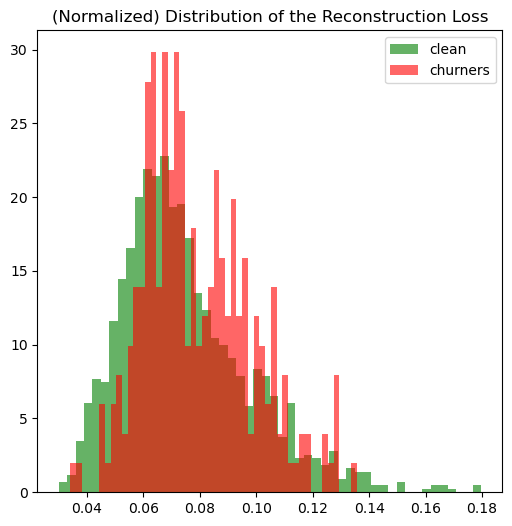

In [113]:
X_test_no_extra_features=X_test.copy()
X_test_no_extra_features=X_test_no_extra_features.drop(['iso','lof_score','probability'],axis=1)
X_test_encoder = pipeline_norm_scaler.transform(X_test_no_extra_features)
reconstructions,mean,logvar = vae.predict(X_test_encoder)
mse = np.mean(np.square(X_test_encoder - reconstructions), axis=1)


clean = mse[y_test==0]
fraud = mse[y_test==1]
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="churners", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.legend()
plt.show()

The classifications using the MAD method with threshold=2 are as follows:
[[1334  100]
 [ 229   19]]

% of transactions labeled as fraud that were correct (precision): 19/(100+19) = 15.97%
% of fraudulent transactions were caught successfully (recall):    19/(229+19) = 7.66%


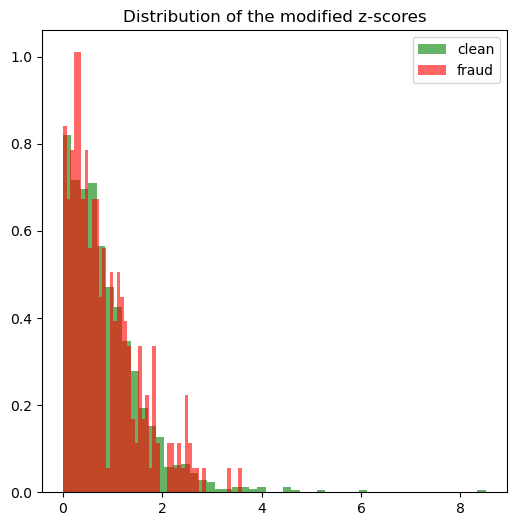

In [112]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve

THRESHOLD = 2

def mad_score(points):
    m = np.median(points)
    ad = np.abs(points - m)
    mad = np.median(ad)
    
    return 0.6745 * ad / mad

z_scores = mad_score(mse)
outliers = z_scores > THRESHOLD

# get (mis)classification
cm = confusion_matrix(y_test, outliers)

# true/false positives/negatives
(tn, fp, 
 fn, tp) = cm.flatten()
print(f"The classifications using the MAD method with threshold={THRESHOLD} are as follows:\n{cm}\n\n% of transactions labeled as fraud that were correct (precision): {tp}/({fp}+{tp}) = {tp/(fp+tp):.2%}\n% of fraudulent transactions were caught successfully (recall):    {tp}/({fn}+{tp}) = {tp/(fn+tp):.2%}")


clean = z_scores[y_test==0]
fraud = z_scores[y_test==1]

fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean, bins=50, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud, bins=50, density=True, label="fraud", alpha=.6, color="red")

plt.title("Distribution of the modified z-scores")
plt.legend()
plt.show()